In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from datetime import datetime
from tensorflow.keras.metrics import top_k_categorical_accuracy, CategoricalHinge, Recall, Precision
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import metrics

import tensorflow.keras
from tensorflow.compat.v2.keras.layers import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
tf.compat.v1.disable_eager_execution
pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

#np.random.seed(368)
#tf.random.set_seed(368)

In [3]:
xfile='C:\\workspace\\j6stock\\xau_usd_OHLC2.0Tp1.0Cl100Vp.txt'

seq_len = 60*10 # 3 days + 2 features is enough memory
batch_size = 2048*2       # Batch size
mini_batch_size = 64       # Batch size

learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 1


y_column = 6
compute_val_at = 0
acc_filtered_r = 0.8


import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
#from keras.models import load_model
#import keras
import pandas as pd ## can be remove once pandas_datareader 0.7 using
pd.core.common.is_list_like = pd.api.types.is_list_like ## can be remove once pandas_datareader 0.7 using
import pandas_datareader.data as web
import h5py
import os

#from keras import backend as K

def make_window_dataset(ds, window_size=5, shift=1, stride=1):
    windows = ds.window(window_size, shift=shift, stride=stride)

    def sub_to_batch(sub, y):
        print (sub)
        print (y)
        s = sub.batch(window_size, drop_remainder=True)
        yy = y.batch(window_size, drop_remainder=True)
        return (s, yy)

    windows = windows.flat_map(sub_to_batch)
    return windows


def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    df['tail'] = df['low']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
        df.at[i, 'tail'] = df.at[i, 'high'] if df.at[i, 'high'] > df.at[i, 'low'] else ( df.at[i, 'low'] * -1)
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
    
        
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        #df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        #df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        df['tail'] = min_max_scaler.fit_transform(df['tail'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))   
                #pd.concat([min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1)), df], axis=1)
                ma_data = df['{}ma'.format(moving)]
                df.drop(labels=['{}ma'.format(moving)], axis=1, inplace=True)
                df = pd.concat([ma_data, df], axis=1)
    
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
    
    #drop for wavenet and not enough memory
    #df.drop(labels=['change'], axis=1, inplace=True)
    df.drop(labels=['high'], axis=1, inplace=True)
    df.drop(labels=['low'], axis=1, inplace=True)
    
    return df

#df = get_stock_data( ma=[50, 100, 200])
df = get_stock_data(ma=[240])
input2Length = 2
amount_of_features = len(df.columns)-1+(input2Length*-1)

def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    x_result2 = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,
                             :-1 + (input2Length*-1) # -2 is ignore Input2 features
                            ]) # index : index + 22days
        x_result2.append(data[index, -1 + (input2Length*-1):-1])
        y_result.append(data[index ,-1]);

    x_result, x_result2, y_result = shuffle(x_result, x_result2, y_result , random_state=2)

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    x_result2 = np.array(x_result2)
    y_result = np.array(y_result)
    print ("Amount of data = {}".format(y_result.shape[0]))

    percentageSplit = 0.5 # 60% split
    row = round(percentageSplit * y_result.shape[0]) 
    print ("Split = {}".format(row))
 
    X_train = x_result[:int(row), :] 
    X_train2 = x_result2[:int(row), :] 
    y_train = y_result[:int(row)] 
    print ("Amount of training data = {}".format(y_train.shape[0]))
    X_test = x_result[int(row):, :]
    X_test2 = x_result2[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    X_test2 = X_test2[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    
    # split 50% again for test and validation set
    row = round(percentageSplit * y_test.shape[0]) 
    X_val = X_test[int(row):, :]
    X_val2 = X_test2[int(row):, :]
    y_val = y_test[int(row):]
    print ("Amount of validation data = {}".format(y_val.shape[0]))
    X_test = X_test[:int(row), :]
    X_test2 = X_test2[:int(row), :]
    y_test = y_test[:int(row)]
    print ("Amount of testing data = {}".format(y_test.shape[0]))
    

           
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, X_train2, y_train, X_test, X_test2, y_test, X_val, X_val2, y_val]



classes = [1, 0, -1]
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.transform([-1, 0, 1])

X_tr, X_tr2, lab_tr, X_test, X_test2, lab_test, X_vld, X_vld2, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
y_test = lb.transform(lab_test)


train_X = X_tr
train_X2 = X_tr2
train_y = y_tr
valid_X = X_vld
valid_X2 = X_vld2
valid_y = y_vld
test_X = X_test
test_X2 = X_test2
test_y = y_test
print(train_X.shape)
print(train_y[0])
print(train_y[1])
print(train_y[2])

Amount of features = 2


C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction\lib\site-packages\ipykernel_launcher.py:119: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Amount of data = 947075
Split = 473538
Amount of training data = 473538
Amount of validation data = 84122
Amount of testing data = 84122
(473538, 600, 2)
[0 1 0]
[1 0 0]
[0 1 0]


In [4]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [5]:

def CnnTransformerModel():
#    i = tf.compat.v2.keras.layers.Flatten(input_shape=(batch_size, amount_of_features))
    i = tf.compat.v2.keras.layers.Input(shape = (seq_len, amount_of_features)#, batch_size=mini_batch_size
                                       )
    
    x = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 4, strides = 2)(i)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('relu')(x)
    x = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 4, strides = 2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('relu')(x)
    x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, strides = 2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('relu')(x)
    x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, strides = 2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('relu')(x)
    
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(i)
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
 
#    x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=15, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    tailInput = Input(shape=(2,))
    tailLayers = Dense(3, activation='softmax')(tailInput)
    
    concat = concatenate([avg_pool, max_pool, tailLayers])
    y = Dense(3,activation = 'relu')(concat)
    

    return Model(inputs = [i, tailInput], outputs = [y, tailLayers])

In [6]:
model = CnnTransformerModel()
optimizer = tf.keras.optimizers.Adam(lr=0.090, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy',
                          loss_weights=[1., 0.2]
#                             , metrics=[Recall() #Recall(thresholds=0.5, class_id=0, top_k=1)
                       #           , Recall(thresholds=0.5, class_id=2, top_k=1)
                      #              , Precision(thresholds=0.5, class_id=0, top_k=1)
                       #            , Precision(thresholds=0.5, class_id=2, top_k=1)
#                                   ]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 2)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 299, 64)      576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 299, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 299, 64)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

**Visualizing The Model Architecture**

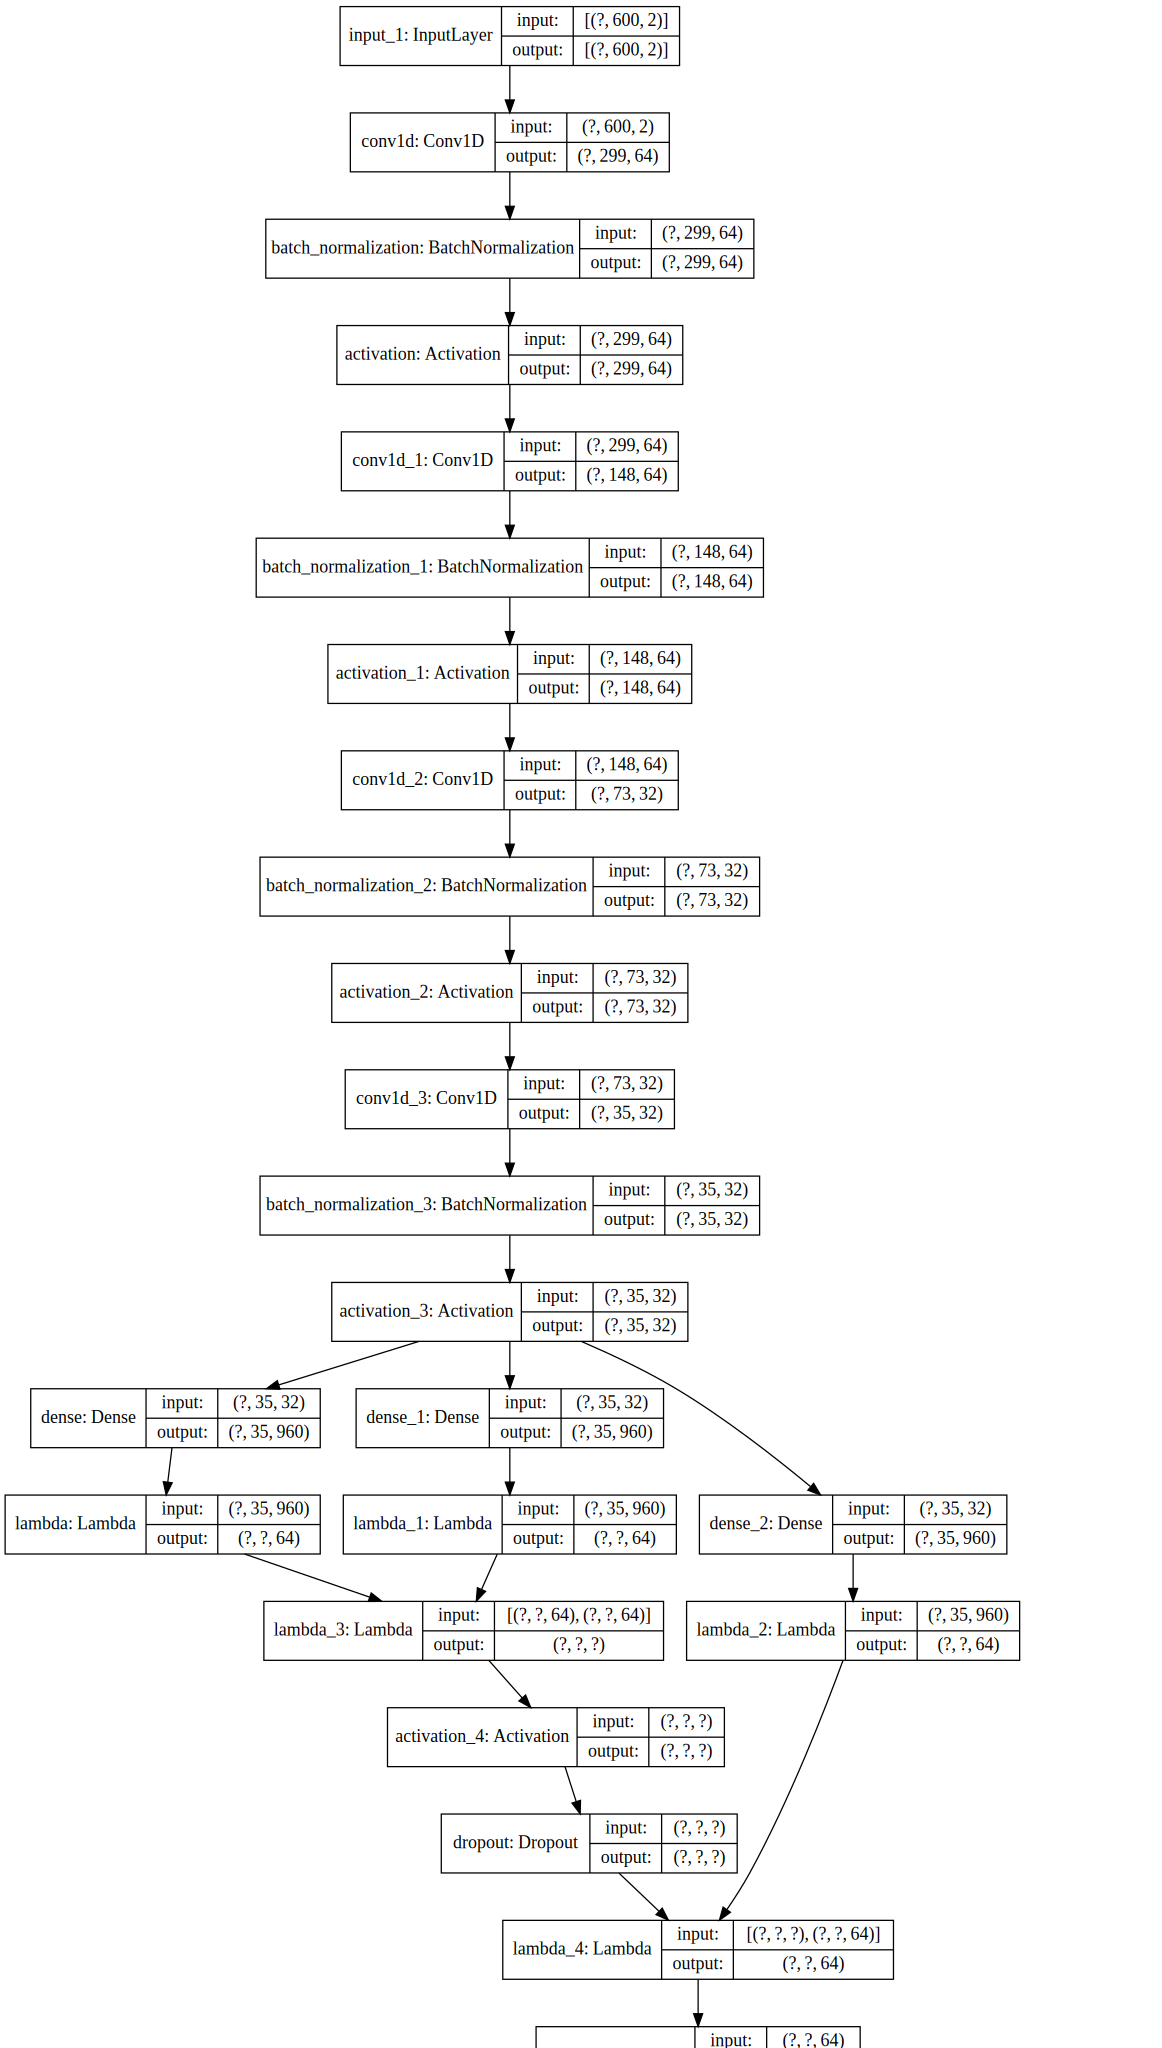

In [7]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [8]:
from datetime import datetime
logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=500) 
callbacks_list = [checkpoint
                  , early
                  , reduceLROnPlat
                  , tensorboard_callback
                 ]

from IPython.display import clear_output
model.fit([train_X, train_X2], [train_y, train_y],
                      validation_data = ([valid_X, valid_X2], [valid_y, valid_y]), 
                      batch_size = batch_size,
                      epochs = 500,
                      callbacks = callbacks_list)
#clear_output()

W1019 08:33:05.774775  8840 callbacks.py:1781] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Train on 473538 samples, validate on 84122 samples


W1019 08:33:06.148860  8840 summary_ops_v2.py:1110] Model failed to serialize as JSON. Ignoring... Layers with arguments in `__init__` must override `get_config`.


Epoch 1/500


W1019 08:33:06.478507  8840 deprecation.py:323] From C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


471040/473538 [============================>.] - ETA: 18:34 - loss: 5.1699 - dense_5_loss: 4.9183 - dense_4_loss: 1.25 - ETA: 9:48 - loss: 3.1760 - dense_5_loss: 2.9371 - dense_4_loss: 1.1946 - ETA: 6:41 - loss: 2.5042 - dense_5_loss: 2.2760 - dense_4_loss: 1.141 - ETA: 5:07 - loss: 2.1610 - dense_5_loss: 1.9416 - dense_4_loss: 1.097 - ETA: 4:11 - loss: 1.9500 - dense_5_loss: 1.7374 - dense_4_loss: 1.062 - ETA: 3:33 - loss: 1.8049 - dense_5_loss: 1.5977 - dense_4_loss: 1.035 - ETA: 3:06 - loss: 1.7015 - dense_5_loss: 1.4981 - dense_4_loss: 1.017 - ETA: 2:46 - loss: 1.6255 - dense_5_loss: 1.4246 - dense_4_loss: 1.004 - ETA: 2:30 - loss: 1.5630 - dense_5_loss: 1.3645 - dense_4_loss: 0.992 - ETA: 2:17 - loss: 1.5172 - dense_5_loss: 1.3195 - dense_4_loss: 0.988 - ETA: 2:07 - loss: 1.4797 - dense_5_loss: 1.2824 - dense_4_loss: 0.986 - ETA: 1:58 - loss: 1.4474 - dense_5_loss: 1.2506 - dense_4_loss: 0.984 - ETA: 1:51 - loss: 1.4193 - dense_5_loss: 1.2231 - dense_4_loss: 0.981 - ETA: 1:44 - lo

471040/473538 [============================>.] - ETA: 38s - loss: 1.0507 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 38s - loss: 1.0448 - dense_5_loss: 0.8681 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0480 - dense_5_loss: 0.8707 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0515 - dense_5_loss: 0.8738 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0545 - dense_5_loss: 0.8765 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0543 - dense_5_loss: 0.8762 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0527 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0529 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0551 - dense_5_loss: 0.8768 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8771 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0549 - dense_5_loss: 0.8766 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0546 - dense_5_loss: 0.8764 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0548 - dense_5_loss: 0.8764 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0564 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0802 - dense_5_loss: 0.8978 - dense_4_loss: 0.91 - ETA: 37s - loss: 1.0730 - dense_5_loss: 0.8917 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0729 - dense_5_loss: 0.8916 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0707 - dense_5_loss: 0.8896 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0653 - dense_5_loss: 0.8851 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0654 - dense_5_loss: 0.8851 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0649 - dense_5_loss: 0.8846 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0652 - dense_5_loss: 0.8849 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0660 - dense_5_loss: 0.8857 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0659 - dense_5_loss: 0.8856 - dense_4_loss: 0.90 - ETA: 34s - loss: 1.0655 - dense_5_loss: 0.8852 - dense_4_loss: 0.90 - ETA: 34s - loss: 1.0653 - dense_5_loss: 0.8850 - dense_4_loss: 0.90 - ETA: 34s - loss: 1.0655 - dense_5_loss: 0.8852 - dense_4_loss: 0.90 - ETA: 33s - loss: 1.0667 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0891 - dense_5_loss: 0.9057 - dense_4_loss: 0.91 - ETA: 37s - loss: 1.0751 - dense_5_loss: 0.8939 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0716 - dense_5_loss: 0.8906 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0650 - dense_5_loss: 0.8848 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0627 - dense_5_loss: 0.8831 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0608 - dense_5_loss: 0.8814 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0624 - dense_5_loss: 0.8828 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0657 - dense_5_loss: 0.8855 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0649 - dense_5_loss: 0.8849 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0624 - dense_5_loss: 0.8828 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0606 - dense_5_loss: 0.8813 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0620 - dense_5_loss: 0.8824 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0606 - dense_5_loss: 0.8813 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0609 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0693 - dense_5_loss: 0.8896 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0661 - dense_5_loss: 0.8863 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0673 - dense_5_loss: 0.8872 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0720 - dense_5_loss: 0.8910 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0715 - dense_5_loss: 0.8907 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0679 - dense_5_loss: 0.8876 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0647 - dense_5_loss: 0.8849 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0667 - dense_5_loss: 0.8865 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0654 - dense_5_loss: 0.8854 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0675 - dense_5_loss: 0.8872 - dense_4_loss: 0.90 - ETA: 34s - loss: 1.0670 - dense_5_loss: 0.8867 - dense_4_loss: 0.90 - ETA: 34s - loss: 1.0664 - dense_5_loss: 0.8862 - dense_4_loss: 0.90 - ETA: 34s - loss: 1.0664 - dense_5_loss: 0.8862 - dense_4_loss: 0.90 - ETA: 33s - loss: 1.0658 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0461 - dense_5_loss: 0.8694 - dense_4_loss: 0.88 - ETA: 40s - loss: 1.0672 - dense_5_loss: 0.8873 - dense_4_loss: 0.89 - ETA: 39s - loss: 1.0591 - dense_5_loss: 0.8804 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0586 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0577 - dense_5_loss: 0.8789 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0573 - dense_5_loss: 0.8787 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0604 - dense_5_loss: 0.8812 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0616 - dense_5_loss: 0.8823 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0620 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0587 - dense_5_loss: 0.8798 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0607 - dense_5_loss: 0.8815 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0595 - dense_5_loss: 0.8805 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0590 - dense_5_loss: 0.8800 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0587 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 39s - loss: 1.0548 - dense_5_loss: 0.8767 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0523 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 38s - loss: 1.0559 - dense_5_loss: 0.8779 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0573 - dense_5_loss: 0.8789 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0559 - dense_5_loss: 0.8777 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0546 - dense_5_loss: 0.8766 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0532 - dense_5_loss: 0.8753 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0523 - dense_5_loss: 0.8745 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0526 - dense_5_loss: 0.8747 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0550 - dense_5_loss: 0.8767 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0554 - dense_5_loss: 0.8770 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0569 - dense_5_loss: 0.8783 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0579 - dense_5_loss: 0.8791 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0575 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0773 - dense_5_loss: 0.8948 - dense_4_loss: 0.91 - ETA: 37s - loss: 1.0688 - dense_5_loss: 0.8876 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0593 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0574 - dense_5_loss: 0.8782 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0567 - dense_5_loss: 0.8777 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0571 - dense_5_loss: 0.8781 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0613 - dense_5_loss: 0.8818 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0598 - dense_5_loss: 0.8805 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0590 - dense_5_loss: 0.8798 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0589 - dense_5_loss: 0.8799 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0610 - dense_5_loss: 0.8817 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0605 - dense_5_loss: 0.8814 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0607 - dense_5_loss: 0.8816 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0612 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0453 - dense_5_loss: 0.8675 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0525 - dense_5_loss: 0.8739 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0514 - dense_5_loss: 0.8733 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0482 - dense_5_loss: 0.8707 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0498 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0496 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0520 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0505 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0511 - dense_5_loss: 0.8733 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0533 - dense_5_loss: 0.8752 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0550 - dense_5_loss: 0.8766 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0560 - dense_5_loss: 0.8775 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0567 - dense_5_loss: 0.8781 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0574 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 40s - loss: 1.0848 - dense_5_loss: 0.9024 - dense_4_loss: 0.91 - ETA: 39s - loss: 1.0677 - dense_5_loss: 0.8875 - dense_4_loss: 0.90 - ETA: 39s - loss: 1.0717 - dense_5_loss: 0.8909 - dense_4_loss: 0.90 - ETA: 38s - loss: 1.0710 - dense_5_loss: 0.8903 - dense_4_loss: 0.90 - ETA: 38s - loss: 1.0702 - dense_5_loss: 0.8896 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0700 - dense_5_loss: 0.8894 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0713 - dense_5_loss: 0.8906 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0710 - dense_5_loss: 0.8903 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0707 - dense_5_loss: 0.8901 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0696 - dense_5_loss: 0.8891 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0690 - dense_5_loss: 0.8886 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0702 - dense_5_loss: 0.8896 - dense_4_loss: 0.90 - ETA: 34s - loss: 1.0686 - dense_5_loss: 0.8883 - dense_4_loss: 0.90 - ETA: 34s - loss: 1.0671 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0648 - dense_5_loss: 0.8857 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0598 - dense_5_loss: 0.8811 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0617 - dense_5_loss: 0.8823 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0612 - dense_5_loss: 0.8818 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0591 - dense_5_loss: 0.8801 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0617 - dense_5_loss: 0.8822 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0624 - dense_5_loss: 0.8830 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0603 - dense_5_loss: 0.8813 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0579 - dense_5_loss: 0.8794 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0569 - dense_5_loss: 0.8785 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0589 - dense_5_loss: 0.8802 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0594 - dense_5_loss: 0.8806 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0587 - dense_5_loss: 0.8800 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0599 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 39s - loss: 1.0524 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 38s - loss: 1.0554 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0544 - dense_5_loss: 0.8766 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0565 - dense_5_loss: 0.8783 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0576 - dense_5_loss: 0.8792 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0555 - dense_5_loss: 0.8774 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0548 - dense_5_loss: 0.8768 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0554 - dense_5_loss: 0.8772 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0544 - dense_5_loss: 0.8764 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0553 - dense_5_loss: 0.8771 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0551 - dense_5_loss: 0.8770 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0540 - dense_5_loss: 0.8761 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0546 - dense_5_loss: 0.8765 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0543 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0439 - dense_5_loss: 0.8668 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0539 - dense_5_loss: 0.8758 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0528 - dense_5_loss: 0.8750 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0565 - dense_5_loss: 0.8782 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0564 - dense_5_loss: 0.8780 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0537 - dense_5_loss: 0.8758 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0558 - dense_5_loss: 0.8776 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0563 - dense_5_loss: 0.8779 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0575 - dense_5_loss: 0.8790 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0583 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0603 - dense_5_loss: 0.8814 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0615 - dense_5_loss: 0.8824 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0613 - dense_5_loss: 0.8822 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0617 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0601 - dense_5_loss: 0.8818 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0519 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0498 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0521 - dense_5_loss: 0.8745 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0531 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0524 - dense_5_loss: 0.8747 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0544 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0561 - dense_5_loss: 0.8779 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0561 - dense_5_loss: 0.8780 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0579 - dense_5_loss: 0.8795 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0586 - dense_5_loss: 0.8800 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0573 - dense_5_loss: 0.8789 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0575 - dense_5_loss: 0.8790 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0574 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0590 - dense_5_loss: 0.8806 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0674 - dense_5_loss: 0.8877 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0621 - dense_5_loss: 0.8831 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0598 - dense_5_loss: 0.8814 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0609 - dense_5_loss: 0.8822 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0577 - dense_5_loss: 0.8796 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0593 - dense_5_loss: 0.8810 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0589 - dense_5_loss: 0.8806 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0586 - dense_5_loss: 0.8803 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0578 - dense_5_loss: 0.8795 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0585 - dense_5_loss: 0.8801 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0577 - dense_5_loss: 0.8794 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0579 - dense_5_loss: 0.8795 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0586 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0481 - dense_5_loss: 0.8711 - dense_4_loss: 0.88 - ETA: 38s - loss: 1.0576 - dense_5_loss: 0.8791 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0526 - dense_5_loss: 0.8750 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0547 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0558 - dense_5_loss: 0.8777 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0565 - dense_5_loss: 0.8782 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0559 - dense_5_loss: 0.8777 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0547 - dense_5_loss: 0.8765 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8773 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0547 - dense_5_loss: 0.8765 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0562 - dense_5_loss: 0.8779 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0550 - dense_5_loss: 0.8769 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0563 - dense_5_loss: 0.8780 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0556 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0513 - dense_5_loss: 0.8730 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0532 - dense_5_loss: 0.8750 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0572 - dense_5_loss: 0.8787 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0599 - dense_5_loss: 0.8811 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0563 - dense_5_loss: 0.8781 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0555 - dense_5_loss: 0.8775 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0549 - dense_5_loss: 0.8769 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0556 - dense_5_loss: 0.8775 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0551 - dense_5_loss: 0.8771 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0551 - dense_5_loss: 0.8771 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0554 - dense_5_loss: 0.8773 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0562 - dense_5_loss: 0.8780 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0573 - dense_5_loss: 0.8789 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0578 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0687 - dense_5_loss: 0.8888 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0572 - dense_5_loss: 0.8793 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0532 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0549 - dense_5_loss: 0.8771 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0582 - dense_5_loss: 0.8796 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0582 - dense_5_loss: 0.8796 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0584 - dense_5_loss: 0.8799 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0607 - dense_5_loss: 0.8818 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0585 - dense_5_loss: 0.8800 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0581 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0594 - dense_5_loss: 0.8807 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0604 - dense_5_loss: 0.8817 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0603 - dense_5_loss: 0.8816 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0599 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0692 - dense_5_loss: 0.8893 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0726 - dense_5_loss: 0.8922 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0657 - dense_5_loss: 0.8861 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0673 - dense_5_loss: 0.8875 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0671 - dense_5_loss: 0.8873 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0652 - dense_5_loss: 0.8858 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0636 - dense_5_loss: 0.8845 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0629 - dense_5_loss: 0.8839 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0633 - dense_5_loss: 0.8843 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0641 - dense_5_loss: 0.8850 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0630 - dense_5_loss: 0.8840 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0621 - dense_5_loss: 0.8833 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0614 - dense_5_loss: 0.8826 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0609 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0652 - dense_5_loss: 0.8852 - dense_4_loss: 0.90 - ETA: 38s - loss: 1.0558 - dense_5_loss: 0.8774 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0610 - dense_5_loss: 0.8818 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0539 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0507 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0502 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0543 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0558 - dense_5_loss: 0.8776 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0565 - dense_5_loss: 0.8783 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0572 - dense_5_loss: 0.8789 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0582 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0571 - dense_5_loss: 0.8788 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0574 - dense_5_loss: 0.8790 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0577 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0611 - dense_5_loss: 0.8828 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0510 - dense_5_loss: 0.8743 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0464 - dense_5_loss: 0.8707 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0494 - dense_5_loss: 0.8731 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0504 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0549 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0558 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0567 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0588 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0584 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0598 - dense_5_loss: 0.8817 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0609 - dense_5_loss: 0.8826 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0585 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0583 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0406 - dense_5_loss: 0.8655 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0512 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0503 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0540 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0500 - dense_5_loss: 0.8730 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0527 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0546 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0562 - dense_5_loss: 0.8781 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0568 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0579 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0579 - dense_5_loss: 0.8798 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0567 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0563 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0559 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0649 - dense_5_loss: 0.8856 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0590 - dense_5_loss: 0.8809 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0579 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0633 - dense_5_loss: 0.8844 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0608 - dense_5_loss: 0.8822 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0650 - dense_5_loss: 0.8856 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0623 - dense_5_loss: 0.8834 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0600 - dense_5_loss: 0.8815 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0591 - dense_5_loss: 0.8808 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0601 - dense_5_loss: 0.8816 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0597 - dense_5_loss: 0.8814 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0602 - dense_5_loss: 0.8818 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0595 - dense_5_loss: 0.8812 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0594 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0595 - dense_5_loss: 0.8814 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0629 - dense_5_loss: 0.8838 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0594 - dense_5_loss: 0.8811 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0609 - dense_5_loss: 0.8824 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0592 - dense_5_loss: 0.8811 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0613 - dense_5_loss: 0.8829 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0595 - dense_5_loss: 0.8815 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0613 - dense_5_loss: 0.8829 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0608 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0608 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0606 - dense_5_loss: 0.8823 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0607 - dense_5_loss: 0.8823 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0600 - dense_5_loss: 0.8817 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0602 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0598 - dense_5_loss: 0.8813 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0532 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0630 - dense_5_loss: 0.8842 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0686 - dense_5_loss: 0.8889 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0636 - dense_5_loss: 0.8846 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0638 - dense_5_loss: 0.8847 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0638 - dense_5_loss: 0.8848 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0617 - dense_5_loss: 0.8831 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0620 - dense_5_loss: 0.8833 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0614 - dense_5_loss: 0.8829 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0614 - dense_5_loss: 0.8829 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0618 - dense_5_loss: 0.8833 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0612 - dense_5_loss: 0.8827 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0597 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0716 - dense_5_loss: 0.8907 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0653 - dense_5_loss: 0.8853 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0622 - dense_5_loss: 0.8831 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0610 - dense_5_loss: 0.8820 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0587 - dense_5_loss: 0.8803 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0552 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0562 - dense_5_loss: 0.8781 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0572 - dense_5_loss: 0.8790 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0579 - dense_5_loss: 0.8796 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0600 - dense_5_loss: 0.8812 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0596 - dense_5_loss: 0.8810 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0588 - dense_5_loss: 0.8803 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0584 - dense_5_loss: 0.8801 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0590 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0685 - dense_5_loss: 0.8889 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0460 - dense_5_loss: 0.8701 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0453 - dense_5_loss: 0.8697 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0508 - dense_5_loss: 0.8742 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0503 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0513 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0530 - dense_5_loss: 0.8761 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0540 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0573 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0556 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0556 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0557 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0567 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0578 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0749 - dense_5_loss: 0.8941 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0687 - dense_5_loss: 0.8887 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0647 - dense_5_loss: 0.8856 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0642 - dense_5_loss: 0.8851 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0664 - dense_5_loss: 0.8872 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0671 - dense_5_loss: 0.8877 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0652 - dense_5_loss: 0.8859 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0631 - dense_5_loss: 0.8841 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0619 - dense_5_loss: 0.8832 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0617 - dense_5_loss: 0.8831 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0622 - dense_5_loss: 0.8835 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0626 - dense_5_loss: 0.8838 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0621 - dense_5_loss: 0.8834 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0617 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0679 - dense_5_loss: 0.8885 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0698 - dense_5_loss: 0.8896 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0582 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0566 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0575 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0545 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0525 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0521 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0526 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0567 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0566 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0561 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0543 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0424 - dense_5_loss: 0.8671 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0582 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0594 - dense_5_loss: 0.8815 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0549 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0586 - dense_5_loss: 0.8807 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0545 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0562 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0563 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0557 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0565 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0560 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0563 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0577 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0585 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0785 - dense_5_loss: 0.8967 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0722 - dense_5_loss: 0.8916 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0675 - dense_5_loss: 0.8879 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0621 - dense_5_loss: 0.8835 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0646 - dense_5_loss: 0.8856 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0652 - dense_5_loss: 0.8863 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0631 - dense_5_loss: 0.8845 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0625 - dense_5_loss: 0.8840 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0620 - dense_5_loss: 0.8835 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0619 - dense_5_loss: 0.8835 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0611 - dense_5_loss: 0.8828 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0608 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0596 - dense_5_loss: 0.8815 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0591 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0627 - dense_5_loss: 0.8843 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0575 - dense_5_loss: 0.8794 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0539 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0524 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0555 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0553 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0552 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0591 - dense_5_loss: 0.8812 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0608 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0602 - dense_5_loss: 0.8821 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0603 - dense_5_loss: 0.8822 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0595 - dense_5_loss: 0.8814 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0591 - dense_5_loss: 0.8811 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0586 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0425 - dense_5_loss: 0.8668 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0612 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0605 - dense_5_loss: 0.8818 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0597 - dense_5_loss: 0.8813 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0620 - dense_5_loss: 0.8831 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0583 - dense_5_loss: 0.8801 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0593 - dense_5_loss: 0.8810 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0607 - dense_5_loss: 0.8821 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0594 - dense_5_loss: 0.8809 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0602 - dense_5_loss: 0.8816 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0598 - dense_5_loss: 0.8813 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0592 - dense_5_loss: 0.8809 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0578 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0585 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0735 - dense_5_loss: 0.8930 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0611 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0613 - dense_5_loss: 0.8828 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0576 - dense_5_loss: 0.8796 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0558 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0537 - dense_5_loss: 0.8765 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0538 - dense_5_loss: 0.8766 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0573 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0560 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0541 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0561 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0564 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0567 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0675 - dense_5_loss: 0.8890 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0676 - dense_5_loss: 0.8887 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0625 - dense_5_loss: 0.8846 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0590 - dense_5_loss: 0.8815 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0600 - dense_5_loss: 0.8825 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0566 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0560 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0559 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0561 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0558 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0537 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0541 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0547 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0552 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0438 - dense_5_loss: 0.8685 - dense_4_loss: 0.87 - ETA: 38s - loss: 1.0541 - dense_5_loss: 0.8771 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0647 - dense_5_loss: 0.8860 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0637 - dense_5_loss: 0.8851 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0598 - dense_5_loss: 0.8817 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0570 - dense_5_loss: 0.8794 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0535 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0535 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0559 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0537 - dense_5_loss: 0.8766 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0542 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0553 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0560 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0549 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0423 - dense_5_loss: 0.8673 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0589 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0579 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0640 - dense_5_loss: 0.8853 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0617 - dense_5_loss: 0.8834 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0624 - dense_5_loss: 0.8839 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0598 - dense_5_loss: 0.8817 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0585 - dense_5_loss: 0.8804 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0583 - dense_5_loss: 0.8804 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0591 - dense_5_loss: 0.8811 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0589 - dense_5_loss: 0.8809 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0586 - dense_5_loss: 0.8806 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0582 - dense_5_loss: 0.8803 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0578 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0376 - dense_5_loss: 0.8634 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0488 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0536 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0570 - dense_5_loss: 0.8790 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0576 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0585 - dense_5_loss: 0.8803 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0580 - dense_5_loss: 0.8800 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0590 - dense_5_loss: 0.8810 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0585 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0579 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0564 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0551 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0553 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0575 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0707 - dense_5_loss: 0.8912 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0717 - dense_5_loss: 0.8922 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0617 - dense_5_loss: 0.8834 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0625 - dense_5_loss: 0.8841 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0602 - dense_5_loss: 0.8820 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0612 - dense_5_loss: 0.8828 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0598 - dense_5_loss: 0.8818 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0579 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0560 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0566 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0549 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0557 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0555 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0551 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0865 - dense_5_loss: 0.9039 - dense_4_loss: 0.91 - ETA: 37s - loss: 1.0669 - dense_5_loss: 0.8876 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0694 - dense_5_loss: 0.8902 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0682 - dense_5_loss: 0.8893 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0667 - dense_5_loss: 0.8880 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0670 - dense_5_loss: 0.8880 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0647 - dense_5_loss: 0.8860 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0638 - dense_5_loss: 0.8852 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0627 - dense_5_loss: 0.8843 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0632 - dense_5_loss: 0.8847 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0629 - dense_5_loss: 0.8846 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0647 - dense_5_loss: 0.8861 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0625 - dense_5_loss: 0.8842 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0619 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0571 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0670 - dense_5_loss: 0.8878 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0674 - dense_5_loss: 0.8885 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0622 - dense_5_loss: 0.8841 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0598 - dense_5_loss: 0.8819 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0614 - dense_5_loss: 0.8832 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0583 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0587 - dense_5_loss: 0.8810 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0590 - dense_5_loss: 0.8812 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0604 - dense_5_loss: 0.8823 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0578 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0570 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0579 - dense_5_loss: 0.8803 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0576 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0422 - dense_5_loss: 0.8670 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0544 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0537 - dense_5_loss: 0.8769 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0543 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0550 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0554 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0548 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0542 - dense_5_loss: 0.8771 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0558 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0561 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0566 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0551 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0559 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0553 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0546 - dense_5_loss: 0.8771 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0570 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0558 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0538 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0513 - dense_5_loss: 0.8744 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0492 - dense_5_loss: 0.8728 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0521 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0527 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0515 - dense_5_loss: 0.8747 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0528 - dense_5_loss: 0.8758 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0530 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0525 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0525 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0545 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0754 - dense_5_loss: 0.8952 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0699 - dense_5_loss: 0.8906 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0750 - dense_5_loss: 0.8947 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0729 - dense_5_loss: 0.8931 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0694 - dense_5_loss: 0.8901 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0669 - dense_5_loss: 0.8879 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0654 - dense_5_loss: 0.8866 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0633 - dense_5_loss: 0.8848 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0618 - dense_5_loss: 0.8835 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0626 - dense_5_loss: 0.8843 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0615 - dense_5_loss: 0.8834 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0623 - dense_5_loss: 0.8840 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0629 - dense_5_loss: 0.8845 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0621 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0773 - dense_5_loss: 0.8965 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0732 - dense_5_loss: 0.8933 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0651 - dense_5_loss: 0.8864 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0619 - dense_5_loss: 0.8837 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0605 - dense_5_loss: 0.8824 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0586 - dense_5_loss: 0.8807 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0569 - dense_5_loss: 0.8794 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0577 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0579 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0580 - dense_5_loss: 0.8803 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0589 - dense_5_loss: 0.8810 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0574 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0584 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0576 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0525 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0489 - dense_5_loss: 0.8724 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0505 - dense_5_loss: 0.8735 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0481 - dense_5_loss: 0.8718 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0522 - dense_5_loss: 0.8753 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0516 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0514 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0520 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0532 - dense_5_loss: 0.8761 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0540 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0535 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0530 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0537 - dense_5_loss: 0.8765 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0537 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0542 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0524 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0525 - dense_5_loss: 0.8750 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0504 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0580 - dense_5_loss: 0.8798 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0563 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0555 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0567 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0555 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0556 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0556 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0564 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0566 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0575 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0592 - dense_5_loss: 0.8819 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0519 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0542 - dense_5_loss: 0.8769 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0526 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0521 - dense_5_loss: 0.8753 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0532 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0570 - dense_5_loss: 0.8793 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0548 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0554 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0552 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0554 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0572 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0563 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0553 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0533 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0694 - dense_5_loss: 0.8891 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0675 - dense_5_loss: 0.8875 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0671 - dense_5_loss: 0.8875 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0689 - dense_5_loss: 0.8889 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0698 - dense_5_loss: 0.8898 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0687 - dense_5_loss: 0.8888 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0653 - dense_5_loss: 0.8859 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0645 - dense_5_loss: 0.8852 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0633 - dense_5_loss: 0.8843 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0627 - dense_5_loss: 0.8839 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0619 - dense_5_loss: 0.8831 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0627 - dense_5_loss: 0.8838 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0612 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0352 - dense_5_loss: 0.8611 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0403 - dense_5_loss: 0.8651 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0479 - dense_5_loss: 0.8715 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0554 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0548 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0557 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0574 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0584 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0586 - dense_5_loss: 0.8808 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0597 - dense_5_loss: 0.8817 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0591 - dense_5_loss: 0.8811 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0615 - dense_5_loss: 0.8831 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0602 - dense_5_loss: 0.8821 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0601 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0354 - dense_5_loss: 0.8611 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0471 - dense_5_loss: 0.8714 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0507 - dense_5_loss: 0.8745 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0511 - dense_5_loss: 0.8744 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0515 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0542 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0528 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0505 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0498 - dense_5_loss: 0.8733 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0488 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0488 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0501 - dense_5_loss: 0.8736 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0504 - dense_5_loss: 0.8740 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0522 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0644 - dense_5_loss: 0.8860 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0569 - dense_5_loss: 0.8794 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0533 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0551 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0553 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0540 - dense_5_loss: 0.8771 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0561 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0548 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0556 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0569 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0560 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0571 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0558 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0559 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0564 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0666 - dense_5_loss: 0.8877 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0629 - dense_5_loss: 0.8846 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0649 - dense_5_loss: 0.8864 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0657 - dense_5_loss: 0.8870 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0642 - dense_5_loss: 0.8857 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0613 - dense_5_loss: 0.8834 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0625 - dense_5_loss: 0.8844 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0601 - dense_5_loss: 0.8824 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0609 - dense_5_loss: 0.8830 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0613 - dense_5_loss: 0.8835 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0596 - dense_5_loss: 0.8821 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0606 - dense_5_loss: 0.8829 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0613 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0662 - dense_5_loss: 0.8863 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0674 - dense_5_loss: 0.8873 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0608 - dense_5_loss: 0.8819 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0621 - dense_5_loss: 0.8833 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0615 - dense_5_loss: 0.8829 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0601 - dense_5_loss: 0.8817 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0594 - dense_5_loss: 0.8813 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0589 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0625 - dense_5_loss: 0.8840 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0597 - dense_5_loss: 0.8816 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0595 - dense_5_loss: 0.8815 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0599 - dense_5_loss: 0.8819 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0592 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0592 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0528 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0522 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0554 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0521 - dense_5_loss: 0.8753 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0543 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0551 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0579 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0566 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0563 - dense_5_loss: 0.8793 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0561 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0562 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0549 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0542 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0546 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0569 - dense_5_loss: 0.8804 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0491 - dense_5_loss: 0.8739 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0465 - dense_5_loss: 0.8715 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0466 - dense_5_loss: 0.8714 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0453 - dense_5_loss: 0.8702 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0474 - dense_5_loss: 0.8721 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0464 - dense_5_loss: 0.8710 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0474 - dense_5_loss: 0.8719 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0479 - dense_5_loss: 0.8722 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0476 - dense_5_loss: 0.8719 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0473 - dense_5_loss: 0.8718 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0484 - dense_5_loss: 0.8727 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0484 - dense_5_loss: 0.8727 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0496 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0609 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0610 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0640 - dense_5_loss: 0.8857 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0609 - dense_5_loss: 0.8830 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0608 - dense_5_loss: 0.8826 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0591 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0587 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0579 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0580 - dense_5_loss: 0.8804 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0594 - dense_5_loss: 0.8815 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0589 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0589 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0607 - dense_5_loss: 0.8827 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0597 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0450 - dense_5_loss: 0.8696 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0524 - dense_5_loss: 0.8757 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0564 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0561 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0537 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0570 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0566 - dense_5_loss: 0.8793 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0563 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0572 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0582 - dense_5_loss: 0.8807 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0571 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0574 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0580 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0655 - dense_5_loss: 0.8861 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0538 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0553 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0524 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0506 - dense_5_loss: 0.8738 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0498 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0506 - dense_5_loss: 0.8738 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0509 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0487 - dense_5_loss: 0.8722 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0504 - dense_5_loss: 0.8737 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0516 - dense_5_loss: 0.8747 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0517 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0534 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0540 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0588 - dense_5_loss: 0.8807 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0573 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0550 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0559 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0535 - dense_5_loss: 0.8766 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0502 - dense_5_loss: 0.8736 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0526 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0512 - dense_5_loss: 0.8745 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0515 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0513 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0510 - dense_5_loss: 0.8743 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0507 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0502 - dense_5_loss: 0.8737 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0487 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0426 - dense_5_loss: 0.8674 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0522 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0488 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0550 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0503 - dense_5_loss: 0.8737 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0524 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0541 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0533 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0532 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0544 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0545 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0552 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0566 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0575 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0517 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0600 - dense_5_loss: 0.8825 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0587 - dense_5_loss: 0.8812 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0597 - dense_5_loss: 0.8821 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0584 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0589 - dense_5_loss: 0.8812 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0585 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0600 - dense_5_loss: 0.8822 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0602 - dense_5_loss: 0.8826 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0593 - dense_5_loss: 0.8817 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0602 - dense_5_loss: 0.8824 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0610 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0609 - dense_5_loss: 0.8830 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0598 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0772 - dense_5_loss: 0.8952 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0636 - dense_5_loss: 0.8845 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0595 - dense_5_loss: 0.8812 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0529 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0499 - dense_5_loss: 0.8728 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0467 - dense_5_loss: 0.8701 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0516 - dense_5_loss: 0.8743 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0554 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0538 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0572 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0558 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0574 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0582 - dense_5_loss: 0.8802 - dense_4_loss: 0.89 - ETA: 32s - loss: 1.0580 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0472 - dense_5_loss: 0.8708 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0543 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0561 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0556 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0554 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0545 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0541 - dense_5_loss: 0.8769 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0544 - dense_5_loss: 0.8771 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0537 - dense_5_loss: 0.8766 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0533 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0539 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0558 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0568 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0550 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0605 - dense_5_loss: 0.8812 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0671 - dense_5_loss: 0.8874 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0628 - dense_5_loss: 0.8842 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0607 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0613 - dense_5_loss: 0.8833 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0599 - dense_5_loss: 0.8821 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0585 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0579 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0555 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0554 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0560 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0553 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0555 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0554 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0590 - dense_5_loss: 0.8816 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0568 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0567 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0520 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0512 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0513 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0536 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0542 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0527 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0495 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0496 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0492 - dense_5_loss: 0.8731 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0488 - dense_5_loss: 0.8728 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0488 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0566 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0494 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0597 - dense_5_loss: 0.8815 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0587 - dense_5_loss: 0.8807 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0593 - dense_5_loss: 0.8814 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0560 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0532 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0550 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0566 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0553 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0540 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0540 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0545 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0628 - dense_5_loss: 0.8845 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0584 - dense_5_loss: 0.8808 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0599 - dense_5_loss: 0.8819 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0535 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0524 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0542 - dense_5_loss: 0.8769 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0539 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0540 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0533 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0536 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0525 - dense_5_loss: 0.8758 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0528 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0530 - dense_5_loss: 0.8761 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0539 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0528 - dense_5_loss: 0.8768 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0585 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0630 - dense_5_loss: 0.8845 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0554 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0547 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0550 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0541 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0532 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0535 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0525 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0511 - dense_5_loss: 0.8743 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0515 - dense_5_loss: 0.8747 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0522 - dense_5_loss: 0.8753 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0520 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0776 - dense_5_loss: 0.8968 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0698 - dense_5_loss: 0.8901 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0698 - dense_5_loss: 0.8904 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0656 - dense_5_loss: 0.8867 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0638 - dense_5_loss: 0.8853 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0624 - dense_5_loss: 0.8841 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0634 - dense_5_loss: 0.8849 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0617 - dense_5_loss: 0.8836 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0616 - dense_5_loss: 0.8836 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0602 - dense_5_loss: 0.8824 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0601 - dense_5_loss: 0.8822 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0589 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0592 - dense_5_loss: 0.8815 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0581 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0668 - dense_5_loss: 0.8865 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0763 - dense_5_loss: 0.8953 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0716 - dense_5_loss: 0.8914 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0683 - dense_5_loss: 0.8888 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0621 - dense_5_loss: 0.8835 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0608 - dense_5_loss: 0.8825 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0603 - dense_5_loss: 0.8822 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0574 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0565 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0581 - dense_5_loss: 0.8803 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0573 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0569 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0567 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0566 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0329 - dense_5_loss: 0.8598 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0453 - dense_5_loss: 0.8699 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0490 - dense_5_loss: 0.8728 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0514 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0558 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0551 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0545 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0568 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0537 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0549 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0544 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0556 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0546 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0546 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0668 - dense_5_loss: 0.8879 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0681 - dense_5_loss: 0.8891 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0586 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0539 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0550 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0564 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0547 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0555 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0560 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0575 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0588 - dense_5_loss: 0.8812 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0568 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0553 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0543 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0507 - dense_5_loss: 0.8745 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0385 - dense_5_loss: 0.8641 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0396 - dense_5_loss: 0.8649 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0466 - dense_5_loss: 0.8708 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0487 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0494 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0517 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0506 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0497 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0505 - dense_5_loss: 0.8738 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0519 - dense_5_loss: 0.8750 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0516 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0525 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0534 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0741 - dense_5_loss: 0.8946 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0606 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0634 - dense_5_loss: 0.8856 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0611 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0604 - dense_5_loss: 0.8832 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0628 - dense_5_loss: 0.8853 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0600 - dense_5_loss: 0.8828 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0593 - dense_5_loss: 0.8824 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0594 - dense_5_loss: 0.8824 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0581 - dense_5_loss: 0.8814 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0589 - dense_5_loss: 0.8821 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0600 - dense_5_loss: 0.8829 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0597 - dense_5_loss: 0.8826 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0599 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0664 - dense_5_loss: 0.8883 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0645 - dense_5_loss: 0.8868 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0629 - dense_5_loss: 0.8854 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0601 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0587 - dense_5_loss: 0.8819 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0583 - dense_5_loss: 0.8815 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0565 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0566 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0541 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0541 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0550 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0549 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0544 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0551 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0629 - dense_5_loss: 0.8855 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0558 - dense_5_loss: 0.8793 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0619 - dense_5_loss: 0.8847 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0620 - dense_5_loss: 0.8847 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0610 - dense_5_loss: 0.8838 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0631 - dense_5_loss: 0.8857 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0625 - dense_5_loss: 0.8852 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0639 - dense_5_loss: 0.8863 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0624 - dense_5_loss: 0.8851 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0619 - dense_5_loss: 0.8847 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0606 - dense_5_loss: 0.8835 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0612 - dense_5_loss: 0.8840 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0608 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0613 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0512 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0526 - dense_5_loss: 0.8768 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0481 - dense_5_loss: 0.8727 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0511 - dense_5_loss: 0.8750 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0593 - dense_5_loss: 0.8820 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0592 - dense_5_loss: 0.8819 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0571 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0572 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0568 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0557 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0585 - dense_5_loss: 0.8816 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0572 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0584 - dense_5_loss: 0.8816 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0584 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0456 - dense_5_loss: 0.8702 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0502 - dense_5_loss: 0.8744 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0591 - dense_5_loss: 0.8817 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0625 - dense_5_loss: 0.8845 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0630 - dense_5_loss: 0.8850 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0624 - dense_5_loss: 0.8844 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0640 - dense_5_loss: 0.8857 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0623 - dense_5_loss: 0.8843 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0616 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0618 - dense_5_loss: 0.8840 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0627 - dense_5_loss: 0.8848 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0610 - dense_5_loss: 0.8835 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0611 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0624 - dense_5_loss: 0.8845 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0598 - dense_5_loss: 0.8822 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0592 - dense_5_loss: 0.8818 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0603 - dense_5_loss: 0.8828 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0595 - dense_5_loss: 0.8822 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0582 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0565 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0544 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0545 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0529 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0527 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0523 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0530 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0537 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0582 - dense_5_loss: 0.8810 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0578 - dense_5_loss: 0.8808 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0513 - dense_5_loss: 0.8754 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0533 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0565 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0581 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0580 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0604 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0600 - dense_5_loss: 0.8829 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0610 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0604 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0604 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0604 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0604 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0494 - dense_5_loss: 0.8740 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0556 - dense_5_loss: 0.8794 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0483 - dense_5_loss: 0.8732 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0486 - dense_5_loss: 0.8734 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0479 - dense_5_loss: 0.8728 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0525 - dense_5_loss: 0.8766 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0542 - dense_5_loss: 0.8783 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0537 - dense_5_loss: 0.8777 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0536 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0545 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0539 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0544 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0547 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0547 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0506 - dense_5_loss: 0.8756 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0687 - dense_5_loss: 0.8906 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0747 - dense_5_loss: 0.8955 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0742 - dense_5_loss: 0.8948 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0684 - dense_5_loss: 0.8901 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0643 - dense_5_loss: 0.8865 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0609 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0590 - dense_5_loss: 0.8819 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0607 - dense_5_loss: 0.8834 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0611 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0611 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0606 - dense_5_loss: 0.8832 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0594 - dense_5_loss: 0.8822 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0575 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0640 - dense_5_loss: 0.8862 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0545 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0559 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0602 - dense_5_loss: 0.8829 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0624 - dense_5_loss: 0.8847 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0618 - dense_5_loss: 0.8841 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0610 - dense_5_loss: 0.8834 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0607 - dense_5_loss: 0.8832 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0608 - dense_5_loss: 0.8833 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0598 - dense_5_loss: 0.8825 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0601 - dense_5_loss: 0.8828 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0601 - dense_5_loss: 0.8828 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0595 - dense_5_loss: 0.8823 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0594 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0402 - dense_5_loss: 0.8661 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0573 - dense_5_loss: 0.8804 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0635 - dense_5_loss: 0.8860 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0616 - dense_5_loss: 0.8844 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0644 - dense_5_loss: 0.8867 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0641 - dense_5_loss: 0.8865 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0626 - dense_5_loss: 0.8851 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0622 - dense_5_loss: 0.8850 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0618 - dense_5_loss: 0.8845 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0615 - dense_5_loss: 0.8842 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0604 - dense_5_loss: 0.8834 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0596 - dense_5_loss: 0.8826 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0594 - dense_5_loss: 0.8825 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0592 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0666 - dense_5_loss: 0.8892 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0639 - dense_5_loss: 0.8872 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0532 - dense_5_loss: 0.8775 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0581 - dense_5_loss: 0.8816 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0588 - dense_5_loss: 0.8819 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0582 - dense_5_loss: 0.8814 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0556 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0557 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0588 - dense_5_loss: 0.8817 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0583 - dense_5_loss: 0.8812 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0592 - dense_5_loss: 0.8820 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0614 - dense_5_loss: 0.8839 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0618 - dense_5_loss: 0.8843 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0620 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0643 - dense_5_loss: 0.8873 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0626 - dense_5_loss: 0.8850 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0605 - dense_5_loss: 0.8832 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0625 - dense_5_loss: 0.8850 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0618 - dense_5_loss: 0.8843 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0609 - dense_5_loss: 0.8836 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0569 - dense_5_loss: 0.8803 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0576 - dense_5_loss: 0.8808 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0575 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0579 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0568 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0573 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0563 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0562 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0561 - dense_5_loss: 0.8787 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0491 - dense_5_loss: 0.8731 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8787 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0486 - dense_5_loss: 0.8731 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0503 - dense_5_loss: 0.8743 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0512 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0523 - dense_5_loss: 0.8761 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0522 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0550 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0569 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0564 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0560 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0567 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0558 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0427 - dense_5_loss: 0.8671 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0514 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0513 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0564 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0591 - dense_5_loss: 0.8820 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0581 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0579 - dense_5_loss: 0.8810 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0585 - dense_5_loss: 0.8816 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0578 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0540 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0555 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0569 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0558 - dense_5_loss: 0.8793 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0546 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0516 - dense_5_loss: 0.8770 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0536 - dense_5_loss: 0.8781 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0543 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0488 - dense_5_loss: 0.8734 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0517 - dense_5_loss: 0.8758 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0502 - dense_5_loss: 0.8744 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0525 - dense_5_loss: 0.8765 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0529 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0538 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0545 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0543 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0536 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0526 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0530 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0606 - dense_5_loss: 0.8821 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0546 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0577 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0505 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0539 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0541 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0557 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0561 - dense_5_loss: 0.8787 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0558 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0574 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0576 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0592 - dense_5_loss: 0.8817 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0584 - dense_5_loss: 0.8810 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0587 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0750 - dense_5_loss: 0.8954 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0648 - dense_5_loss: 0.8868 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0659 - dense_5_loss: 0.8878 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0676 - dense_5_loss: 0.8892 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0637 - dense_5_loss: 0.8858 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0657 - dense_5_loss: 0.8874 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0646 - dense_5_loss: 0.8864 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0643 - dense_5_loss: 0.8861 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0623 - dense_5_loss: 0.8844 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0615 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0616 - dense_5_loss: 0.8838 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0611 - dense_5_loss: 0.8834 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0626 - dense_5_loss: 0.8847 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0621 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0528 - dense_5_loss: 0.8765 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0574 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0553 - dense_5_loss: 0.8793 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0605 - dense_5_loss: 0.8835 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0608 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0587 - dense_5_loss: 0.8818 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0588 - dense_5_loss: 0.8818 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0594 - dense_5_loss: 0.8824 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0588 - dense_5_loss: 0.8817 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0573 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0568 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0567 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0573 - dense_5_loss: 0.8804 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0563 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0756 - dense_5_loss: 0.8953 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0615 - dense_5_loss: 0.8832 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0575 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0556 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0562 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0542 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0568 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0565 - dense_5_loss: 0.8794 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0556 - dense_5_loss: 0.8787 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0562 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0562 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0571 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0566 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0566 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0651 - dense_5_loss: 0.8861 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0540 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0513 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0552 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0546 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0542 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0556 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0546 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0550 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0535 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0546 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0572 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0570 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0495 - dense_5_loss: 0.8730 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0513 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0514 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0504 - dense_5_loss: 0.8744 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0521 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0491 - dense_5_loss: 0.8733 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0497 - dense_5_loss: 0.8738 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0507 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0490 - dense_5_loss: 0.8733 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0482 - dense_5_loss: 0.8726 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0508 - dense_5_loss: 0.8747 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0512 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0511 - dense_5_loss: 0.8752 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0504 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0896 - dense_5_loss: 0.9081 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0666 - dense_5_loss: 0.8885 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0591 - dense_5_loss: 0.8821 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0565 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0565 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0552 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0574 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0575 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0566 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0582 - dense_5_loss: 0.8810 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0567 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0558 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0576 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0580 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0584 - dense_5_loss: 0.8808 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0659 - dense_5_loss: 0.8877 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0619 - dense_5_loss: 0.8841 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0620 - dense_5_loss: 0.8840 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0630 - dense_5_loss: 0.8852 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0601 - dense_5_loss: 0.8826 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0586 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0567 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0570 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0558 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0556 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0561 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0572 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0580 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0675 - dense_5_loss: 0.8901 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0618 - dense_5_loss: 0.8844 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0645 - dense_5_loss: 0.8864 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0627 - dense_5_loss: 0.8848 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0625 - dense_5_loss: 0.8848 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0621 - dense_5_loss: 0.8844 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0613 - dense_5_loss: 0.8838 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0606 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0612 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0630 - dense_5_loss: 0.8851 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0617 - dense_5_loss: 0.8839 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0617 - dense_5_loss: 0.8839 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0619 - dense_5_loss: 0.8842 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0613 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0519 - dense_5_loss: 0.8757 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0475 - dense_5_loss: 0.8721 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0478 - dense_5_loss: 0.8723 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0481 - dense_5_loss: 0.8728 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0508 - dense_5_loss: 0.8750 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0554 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0541 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0551 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0546 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0539 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0545 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0546 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0541 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0546 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0745 - dense_5_loss: 0.8947 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0701 - dense_5_loss: 0.8907 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0667 - dense_5_loss: 0.8883 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0624 - dense_5_loss: 0.8846 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0608 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0593 - dense_5_loss: 0.8820 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0591 - dense_5_loss: 0.8818 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0605 - dense_5_loss: 0.8831 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0593 - dense_5_loss: 0.8820 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0614 - dense_5_loss: 0.8836 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0624 - dense_5_loss: 0.8844 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0618 - dense_5_loss: 0.8839 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0613 - dense_5_loss: 0.8835 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0606 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0508 - dense_5_loss: 0.8743 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0497 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0572 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0606 - dense_5_loss: 0.8827 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0632 - dense_5_loss: 0.8850 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0599 - dense_5_loss: 0.8824 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0571 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0570 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0553 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0565 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0565 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0572 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0559 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0568 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0769 - dense_5_loss: 0.8969 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0632 - dense_5_loss: 0.8853 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0565 - dense_5_loss: 0.8794 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0558 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0555 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0555 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0546 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0521 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0533 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0542 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0519 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0509 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0501 - dense_5_loss: 0.8740 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0498 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0583 - dense_5_loss: 0.8812 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0690 - dense_5_loss: 0.8898 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0621 - dense_5_loss: 0.8840 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0597 - dense_5_loss: 0.8820 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0588 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0597 - dense_5_loss: 0.8822 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0554 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0519 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0532 - dense_5_loss: 0.8765 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0546 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0547 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0532 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0530 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0523 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0660 - dense_5_loss: 0.8876 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0610 - dense_5_loss: 0.8828 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0570 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0521 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0520 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0517 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0506 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0476 - dense_5_loss: 0.8719 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0500 - dense_5_loss: 0.8738 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0492 - dense_5_loss: 0.8731 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0485 - dense_5_loss: 0.8725 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0492 - dense_5_loss: 0.8731 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0501 - dense_5_loss: 0.8738 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0518 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0534 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0547 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0567 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0510 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0515 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0497 - dense_5_loss: 0.8737 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0501 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0511 - dense_5_loss: 0.8747 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0510 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0503 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0503 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0500 - dense_5_loss: 0.8737 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0499 - dense_5_loss: 0.8738 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0508 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0774 - dense_5_loss: 0.8971 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0638 - dense_5_loss: 0.8857 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0577 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0601 - dense_5_loss: 0.8825 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0595 - dense_5_loss: 0.8821 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0575 - dense_5_loss: 0.8804 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0570 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0546 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0568 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0565 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0548 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0539 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0547 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0534 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0527 - dense_5_loss: 0.8758 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0478 - dense_5_loss: 0.8720 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0471 - dense_5_loss: 0.8713 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0456 - dense_5_loss: 0.8698 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0419 - dense_5_loss: 0.8664 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0444 - dense_5_loss: 0.8687 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0436 - dense_5_loss: 0.8681 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0415 - dense_5_loss: 0.8663 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0431 - dense_5_loss: 0.8677 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0456 - dense_5_loss: 0.8699 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0454 - dense_5_loss: 0.8698 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0467 - dense_5_loss: 0.8709 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0479 - dense_5_loss: 0.8720 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0494 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0471 - dense_5_loss: 0.8720 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0556 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0499 - dense_5_loss: 0.8741 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0505 - dense_5_loss: 0.8744 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0532 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0535 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0537 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0546 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0534 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0529 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0521 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0516 - dense_5_loss: 0.8750 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0527 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0529 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0337 - dense_5_loss: 0.8592 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0396 - dense_5_loss: 0.8647 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0398 - dense_5_loss: 0.8651 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0419 - dense_5_loss: 0.8671 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0448 - dense_5_loss: 0.8696 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0449 - dense_5_loss: 0.8697 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0463 - dense_5_loss: 0.8709 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0471 - dense_5_loss: 0.8715 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0473 - dense_5_loss: 0.8717 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0492 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0490 - dense_5_loss: 0.8730 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0466 - dense_5_loss: 0.8709 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0481 - dense_5_loss: 0.8721 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0489 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0300 - dense_5_loss: 0.8565 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0438 - dense_5_loss: 0.8682 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0519 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0564 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0558 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0591 - dense_5_loss: 0.8814 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0591 - dense_5_loss: 0.8814 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0594 - dense_5_loss: 0.8816 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0575 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0558 - dense_5_loss: 0.8787 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0562 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0587 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0593 - dense_5_loss: 0.8817 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0602 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0528 - dense_5_loss: 0.8764 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0453 - dense_5_loss: 0.8702 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0473 - dense_5_loss: 0.8716 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0519 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0527 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0524 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0531 - dense_5_loss: 0.8766 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0515 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0513 - dense_5_loss: 0.8750 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0507 - dense_5_loss: 0.8744 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0490 - dense_5_loss: 0.8730 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0488 - dense_5_loss: 0.8728 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0492 - dense_5_loss: 0.8730 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0498 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0440 - dense_5_loss: 0.8685 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0410 - dense_5_loss: 0.8662 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0479 - dense_5_loss: 0.8717 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0498 - dense_5_loss: 0.8735 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0476 - dense_5_loss: 0.8718 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0475 - dense_5_loss: 0.8717 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0452 - dense_5_loss: 0.8699 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0429 - dense_5_loss: 0.8679 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0453 - dense_5_loss: 0.8700 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0445 - dense_5_loss: 0.8692 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0445 - dense_5_loss: 0.8692 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0440 - dense_5_loss: 0.8687 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0457 - dense_5_loss: 0.8701 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0451 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0594 - dense_5_loss: 0.8813 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0531 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0513 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0525 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0533 - dense_5_loss: 0.8761 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0532 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0539 - dense_5_loss: 0.8766 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0544 - dense_5_loss: 0.8771 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0524 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0523 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0511 - dense_5_loss: 0.8744 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0509 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0506 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0504 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0528 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0509 - dense_5_loss: 0.8743 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0550 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0523 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0515 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0506 - dense_5_loss: 0.8740 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0504 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0511 - dense_5_loss: 0.8745 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0486 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0488 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0482 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0500 - dense_5_loss: 0.8735 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0508 - dense_5_loss: 0.8742 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0508 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0633 - dense_5_loss: 0.8846 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0507 - dense_5_loss: 0.8737 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0525 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0519 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0510 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0507 - dense_5_loss: 0.8737 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0542 - dense_5_loss: 0.8766 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0543 - dense_5_loss: 0.8769 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0531 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0521 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0534 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0546 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0536 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0534 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0449 - dense_5_loss: 0.8691 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0579 - dense_5_loss: 0.8798 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0580 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0572 - dense_5_loss: 0.8793 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0562 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0580 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0562 - dense_5_loss: 0.8788 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0550 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0537 - dense_5_loss: 0.8765 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0526 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0531 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0528 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0542 - dense_5_loss: 0.8771 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0546 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0425 - dense_5_loss: 0.8669 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0481 - dense_5_loss: 0.8718 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0451 - dense_5_loss: 0.8687 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0494 - dense_5_loss: 0.8724 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0535 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0549 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0529 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0512 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0518 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0517 - dense_5_loss: 0.8745 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0515 - dense_5_loss: 0.8743 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0504 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0501 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0502 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0481 - dense_5_loss: 0.8717 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0505 - dense_5_loss: 0.8740 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0508 - dense_5_loss: 0.8743 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0551 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0553 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0568 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0548 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0551 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0526 - dense_5_loss: 0.8758 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0524 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0488 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0491 - dense_5_loss: 0.8727 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0495 - dense_5_loss: 0.8731 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0489 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0393 - dense_5_loss: 0.8648 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0508 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0493 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0501 - dense_5_loss: 0.8733 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0512 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0483 - dense_5_loss: 0.8717 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0462 - dense_5_loss: 0.8700 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0464 - dense_5_loss: 0.8704 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0470 - dense_5_loss: 0.8709 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0484 - dense_5_loss: 0.8722 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0484 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0497 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0507 - dense_5_loss: 0.8740 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0506 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0537 - dense_5_loss: 0.8765 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0557 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0544 - dense_5_loss: 0.8771 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0534 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0483 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0492 - dense_5_loss: 0.8728 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0475 - dense_5_loss: 0.8714 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0487 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0492 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0481 - dense_5_loss: 0.8717 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0486 - dense_5_loss: 0.8722 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0496 - dense_5_loss: 0.8730 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0486 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0479 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0646 - dense_5_loss: 0.8853 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0554 - dense_5_loss: 0.8779 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0559 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0521 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0550 - dense_5_loss: 0.8776 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0573 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0544 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0545 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0529 - dense_5_loss: 0.8758 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0500 - dense_5_loss: 0.8733 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0481 - dense_5_loss: 0.8716 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0490 - dense_5_loss: 0.8724 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0493 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0474 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0631 - dense_5_loss: 0.8845 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0560 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0513 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0527 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0533 - dense_5_loss: 0.8761 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0476 - dense_5_loss: 0.8713 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0478 - dense_5_loss: 0.8714 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0491 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0501 - dense_5_loss: 0.8731 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0499 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0511 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0514 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0526 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0536 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0388 - dense_5_loss: 0.8649 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0375 - dense_5_loss: 0.8632 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0439 - dense_5_loss: 0.8683 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0422 - dense_5_loss: 0.8667 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0485 - dense_5_loss: 0.8722 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0503 - dense_5_loss: 0.8736 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0495 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0509 - dense_5_loss: 0.8742 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0500 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0492 - dense_5_loss: 0.8730 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0507 - dense_5_loss: 0.8742 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0498 - dense_5_loss: 0.8735 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0502 - dense_5_loss: 0.8738 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0521 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0608 - dense_5_loss: 0.8830 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0597 - dense_5_loss: 0.8824 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0592 - dense_5_loss: 0.8821 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0582 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0589 - dense_5_loss: 0.8819 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0583 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0578 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0580 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0552 - dense_5_loss: 0.8787 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0562 - dense_5_loss: 0.8794 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0567 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0569 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0583 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0578 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0489 - dense_5_loss: 0.8722 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0554 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0597 - dense_5_loss: 0.8819 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0612 - dense_5_loss: 0.8834 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0605 - dense_5_loss: 0.8830 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0564 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0578 - dense_5_loss: 0.8807 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0533 - dense_5_loss: 0.8769 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0513 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0516 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0515 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0508 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0520 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0506 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0338 - dense_5_loss: 0.8601 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0425 - dense_5_loss: 0.8677 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0478 - dense_5_loss: 0.8722 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0436 - dense_5_loss: 0.8681 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0484 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0516 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0520 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0519 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0518 - dense_5_loss: 0.8750 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0518 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0501 - dense_5_loss: 0.8735 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0501 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0507 - dense_5_loss: 0.8740 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0501 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0434 - dense_5_loss: 0.8684 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0423 - dense_5_loss: 0.8672 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0428 - dense_5_loss: 0.8671 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0453 - dense_5_loss: 0.8695 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0449 - dense_5_loss: 0.8690 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0477 - dense_5_loss: 0.8712 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0487 - dense_5_loss: 0.8722 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0506 - dense_5_loss: 0.8736 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0491 - dense_5_loss: 0.8724 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0480 - dense_5_loss: 0.8714 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0504 - dense_5_loss: 0.8735 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0511 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0500 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0488 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0563 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0539 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0575 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0584 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0567 - dense_5_loss: 0.8791 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0579 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0526 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0541 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0531 - dense_5_loss: 0.8759 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0547 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0555 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0542 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0533 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0532 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0521 - dense_5_loss: 0.8741 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0438 - dense_5_loss: 0.8676 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0446 - dense_5_loss: 0.8681 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0450 - dense_5_loss: 0.8682 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0460 - dense_5_loss: 0.8691 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0474 - dense_5_loss: 0.8705 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0461 - dense_5_loss: 0.8693 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0477 - dense_5_loss: 0.8708 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0475 - dense_5_loss: 0.8705 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0478 - dense_5_loss: 0.8708 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0484 - dense_5_loss: 0.8713 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0493 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0488 - dense_5_loss: 0.8717 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0490 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0579 - dense_5_loss: 0.8790 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0554 - dense_5_loss: 0.8768 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0613 - dense_5_loss: 0.8821 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0593 - dense_5_loss: 0.8803 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0558 - dense_5_loss: 0.8773 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0559 - dense_5_loss: 0.8777 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0549 - dense_5_loss: 0.8768 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0537 - dense_5_loss: 0.8758 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0520 - dense_5_loss: 0.8745 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0508 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0491 - dense_5_loss: 0.8720 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0488 - dense_5_loss: 0.8718 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0499 - dense_5_loss: 0.8727 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0495 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0184 - dense_5_loss: 0.8471 - dense_4_loss: 0.85 - ETA: 35s - loss: 1.0335 - dense_5_loss: 0.8590 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0436 - dense_5_loss: 0.8677 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0384 - dense_5_loss: 0.8628 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0411 - dense_5_loss: 0.8651 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0415 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0415 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0412 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0421 - dense_5_loss: 0.8657 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0412 - dense_5_loss: 0.8649 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0424 - dense_5_loss: 0.8659 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0439 - dense_5_loss: 0.8672 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0440 - dense_5_loss: 0.8673 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0431 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0592 - dense_5_loss: 0.8810 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0448 - dense_5_loss: 0.8688 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0464 - dense_5_loss: 0.8700 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0440 - dense_5_loss: 0.8681 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0478 - dense_5_loss: 0.8714 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0485 - dense_5_loss: 0.8720 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0493 - dense_5_loss: 0.8724 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0506 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0513 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0510 - dense_5_loss: 0.8737 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0503 - dense_5_loss: 0.8731 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0504 - dense_5_loss: 0.8731 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0489 - dense_5_loss: 0.8718 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0492 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0506 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0434 - dense_5_loss: 0.8669 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0435 - dense_5_loss: 0.8670 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0427 - dense_5_loss: 0.8665 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0418 - dense_5_loss: 0.8657 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0457 - dense_5_loss: 0.8689 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0450 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0459 - dense_5_loss: 0.8691 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0450 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0458 - dense_5_loss: 0.8691 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0442 - dense_5_loss: 0.8678 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0450 - dense_5_loss: 0.8685 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0457 - dense_5_loss: 0.8691 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0471 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0403 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0462 - dense_5_loss: 0.8697 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0429 - dense_5_loss: 0.8671 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0468 - dense_5_loss: 0.8705 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0436 - dense_5_loss: 0.8676 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0459 - dense_5_loss: 0.8695 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0463 - dense_5_loss: 0.8699 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0482 - dense_5_loss: 0.8715 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0491 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0491 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0488 - dense_5_loss: 0.8719 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0497 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0487 - dense_5_loss: 0.8718 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0481 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0451 - dense_5_loss: 0.8699 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0457 - dense_5_loss: 0.8703 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0414 - dense_5_loss: 0.8667 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0442 - dense_5_loss: 0.8690 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0471 - dense_5_loss: 0.8712 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0443 - dense_5_loss: 0.8686 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0452 - dense_5_loss: 0.8694 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0465 - dense_5_loss: 0.8706 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0441 - dense_5_loss: 0.8687 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0463 - dense_5_loss: 0.8706 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0472 - dense_5_loss: 0.8714 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0466 - dense_5_loss: 0.8710 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0471 - dense_5_loss: 0.8712 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0475 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0359 - dense_5_loss: 0.8600 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0401 - dense_5_loss: 0.8640 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0479 - dense_5_loss: 0.8709 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0486 - dense_5_loss: 0.8715 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0504 - dense_5_loss: 0.8728 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0503 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0491 - dense_5_loss: 0.8716 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0494 - dense_5_loss: 0.8718 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0472 - dense_5_loss: 0.8700 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0450 - dense_5_loss: 0.8681 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0453 - dense_5_loss: 0.8685 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0461 - dense_5_loss: 0.8692 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0481 - dense_5_loss: 0.8709 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0487 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0394 - dense_5_loss: 0.8634 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0430 - dense_5_loss: 0.8655 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0474 - dense_5_loss: 0.8693 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0502 - dense_5_loss: 0.8718 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0475 - dense_5_loss: 0.8695 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0489 - dense_5_loss: 0.8709 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0462 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0440 - dense_5_loss: 0.8666 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0459 - dense_5_loss: 0.8682 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0467 - dense_5_loss: 0.8689 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0445 - dense_5_loss: 0.8670 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0444 - dense_5_loss: 0.8670 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0443 - dense_5_loss: 0.8669 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0441 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0355 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0374 - dense_5_loss: 0.8619 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0365 - dense_5_loss: 0.8609 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0325 - dense_5_loss: 0.8573 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8598 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8600 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0348 - dense_5_loss: 0.8595 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0364 - dense_5_loss: 0.8608 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0358 - dense_5_loss: 0.8604 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8608 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0378 - dense_5_loss: 0.8620 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0385 - dense_5_loss: 0.8626 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0387 - dense_5_loss: 0.8628 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0397 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0422 - dense_5_loss: 0.8659 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0307 - dense_5_loss: 0.8561 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0258 - dense_5_loss: 0.8516 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8582 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0390 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0397 - dense_5_loss: 0.8635 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0412 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0420 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0389 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0398 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0405 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0401 - dense_5_loss: 0.8639 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0397 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0397 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0467 - dense_5_loss: 0.8694 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0492 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0511 - dense_5_loss: 0.8736 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0509 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0460 - dense_5_loss: 0.8694 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0458 - dense_5_loss: 0.8690 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0477 - dense_5_loss: 0.8704 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0467 - dense_5_loss: 0.8695 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0470 - dense_5_loss: 0.8697 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0462 - dense_5_loss: 0.8691 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0448 - dense_5_loss: 0.8678 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0433 - dense_5_loss: 0.8664 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0439 - dense_5_loss: 0.8670 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0436 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0442 - dense_5_loss: 0.8668 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0410 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0396 - dense_5_loss: 0.8634 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0385 - dense_5_loss: 0.8623 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8615 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8603 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8596 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8592 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0364 - dense_5_loss: 0.8607 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0366 - dense_5_loss: 0.8607 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0376 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0377 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0437 - dense_5_loss: 0.8677 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0528 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0755 - dense_5_loss: 0.8957 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0682 - dense_5_loss: 0.8901 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0624 - dense_5_loss: 0.8851 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0577 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0636 - dense_5_loss: 0.8860 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0623 - dense_5_loss: 0.8850 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0634 - dense_5_loss: 0.8858 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0609 - dense_5_loss: 0.8837 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0604 - dense_5_loss: 0.8832 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0600 - dense_5_loss: 0.8829 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0591 - dense_5_loss: 0.8821 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0598 - dense_5_loss: 0.8828 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0594 - dense_5_loss: 0.8825 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0583 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0679 - dense_5_loss: 0.8897 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0787 - dense_5_loss: 0.8992 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0663 - dense_5_loss: 0.8887 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0656 - dense_5_loss: 0.8879 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0624 - dense_5_loss: 0.8852 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0583 - dense_5_loss: 0.8817 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0620 - dense_5_loss: 0.8847 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0623 - dense_5_loss: 0.8849 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0617 - dense_5_loss: 0.8844 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0622 - dense_5_loss: 0.8849 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0616 - dense_5_loss: 0.8844 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0610 - dense_5_loss: 0.8839 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0606 - dense_5_loss: 0.8835 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0597 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0569 - dense_5_loss: 0.8803 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0583 - dense_5_loss: 0.8817 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0550 - dense_5_loss: 0.8791 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0595 - dense_5_loss: 0.8828 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0563 - dense_5_loss: 0.8801 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0547 - dense_5_loss: 0.8787 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0552 - dense_5_loss: 0.8790 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0565 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0562 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0562 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0558 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0549 - dense_5_loss: 0.8786 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0543 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0550 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0658 - dense_5_loss: 0.8877 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0674 - dense_5_loss: 0.8893 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0620 - dense_5_loss: 0.8850 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0576 - dense_5_loss: 0.8810 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0606 - dense_5_loss: 0.8836 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0578 - dense_5_loss: 0.8812 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0587 - dense_5_loss: 0.8820 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0581 - dense_5_loss: 0.8815 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0583 - dense_5_loss: 0.8817 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0578 - dense_5_loss: 0.8811 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0580 - dense_5_loss: 0.8813 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0570 - dense_5_loss: 0.8805 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0568 - dense_5_loss: 0.8804 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0556 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0587 - dense_5_loss: 0.8807 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0469 - dense_5_loss: 0.8708 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0452 - dense_5_loss: 0.8695 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0486 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0483 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0488 - dense_5_loss: 0.8727 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0484 - dense_5_loss: 0.8725 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0490 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0515 - dense_5_loss: 0.8751 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0517 - dense_5_loss: 0.8753 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0520 - dense_5_loss: 0.8757 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0526 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0531 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0536 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0475 - dense_5_loss: 0.8728 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0525 - dense_5_loss: 0.8767 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0581 - dense_5_loss: 0.8816 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0589 - dense_5_loss: 0.8822 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0573 - dense_5_loss: 0.8807 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0573 - dense_5_loss: 0.8806 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0568 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0578 - dense_5_loss: 0.8810 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0570 - dense_5_loss: 0.8804 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0568 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0565 - dense_5_loss: 0.8799 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0572 - dense_5_loss: 0.8804 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0568 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0580 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0709 - dense_5_loss: 0.8917 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0616 - dense_5_loss: 0.8842 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0591 - dense_5_loss: 0.8823 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0575 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0575 - dense_5_loss: 0.8809 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0568 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0565 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0564 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0566 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0564 - dense_5_loss: 0.8796 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0562 - dense_5_loss: 0.8794 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0572 - dense_5_loss: 0.8802 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0552 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0558 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0563 - dense_5_loss: 0.8795 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0539 - dense_5_loss: 0.8777 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0537 - dense_5_loss: 0.8773 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0480 - dense_5_loss: 0.8722 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0488 - dense_5_loss: 0.8730 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0466 - dense_5_loss: 0.8710 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0474 - dense_5_loss: 0.8719 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0495 - dense_5_loss: 0.8737 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0522 - dense_5_loss: 0.8760 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0515 - dense_5_loss: 0.8754 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0526 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0532 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0539 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0542 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0649 - dense_5_loss: 0.8874 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0503 - dense_5_loss: 0.8747 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0462 - dense_5_loss: 0.8710 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0475 - dense_5_loss: 0.8722 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0499 - dense_5_loss: 0.8740 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0506 - dense_5_loss: 0.8747 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0487 - dense_5_loss: 0.8732 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0492 - dense_5_loss: 0.8735 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0483 - dense_5_loss: 0.8727 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0471 - dense_5_loss: 0.8717 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0467 - dense_5_loss: 0.8713 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0474 - dense_5_loss: 0.8718 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0468 - dense_5_loss: 0.8713 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0475 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0558 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0481 - dense_5_loss: 0.8720 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0400 - dense_5_loss: 0.8653 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0419 - dense_5_loss: 0.8668 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0460 - dense_5_loss: 0.8704 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0439 - dense_5_loss: 0.8686 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0443 - dense_5_loss: 0.8689 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0452 - dense_5_loss: 0.8696 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0471 - dense_5_loss: 0.8711 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0460 - dense_5_loss: 0.8702 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0456 - dense_5_loss: 0.8699 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0471 - dense_5_loss: 0.8711 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0480 - dense_5_loss: 0.8720 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0480 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0541 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0575 - dense_5_loss: 0.8797 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0522 - dense_5_loss: 0.8753 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0489 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0501 - dense_5_loss: 0.8736 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0511 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0556 - dense_5_loss: 0.8780 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0540 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0492 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0481 - dense_5_loss: 0.8715 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0492 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0500 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0501 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0490 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0533 - dense_5_loss: 0.8758 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0462 - dense_5_loss: 0.8699 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0524 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0500 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0482 - dense_5_loss: 0.8716 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0488 - dense_5_loss: 0.8720 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0479 - dense_5_loss: 0.8713 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0505 - dense_5_loss: 0.8736 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0497 - dense_5_loss: 0.8728 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0493 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0493 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0493 - dense_5_loss: 0.8727 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0489 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0485 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0387 - dense_5_loss: 0.8628 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0498 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0466 - dense_5_loss: 0.8695 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0445 - dense_5_loss: 0.8678 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0464 - dense_5_loss: 0.8698 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0452 - dense_5_loss: 0.8688 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0449 - dense_5_loss: 0.8686 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0439 - dense_5_loss: 0.8678 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0436 - dense_5_loss: 0.8676 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0438 - dense_5_loss: 0.8677 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0444 - dense_5_loss: 0.8682 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0455 - dense_5_loss: 0.8693 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0463 - dense_5_loss: 0.8700 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0465 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0506 - dense_5_loss: 0.8736 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0358 - dense_5_loss: 0.8611 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0376 - dense_5_loss: 0.8623 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0372 - dense_5_loss: 0.8619 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0400 - dense_5_loss: 0.8643 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0423 - dense_5_loss: 0.8662 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0464 - dense_5_loss: 0.8698 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0479 - dense_5_loss: 0.8711 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0479 - dense_5_loss: 0.8712 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0484 - dense_5_loss: 0.8715 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0484 - dense_5_loss: 0.8716 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0492 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0490 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0487 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0655 - dense_5_loss: 0.8859 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0570 - dense_5_loss: 0.8786 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0531 - dense_5_loss: 0.8755 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0516 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0482 - dense_5_loss: 0.8712 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0483 - dense_5_loss: 0.8712 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0498 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0497 - dense_5_loss: 0.8724 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0496 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0498 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0501 - dense_5_loss: 0.8728 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0504 - dense_5_loss: 0.8731 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0496 - dense_5_loss: 0.8724 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0505 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0405 - dense_5_loss: 0.8640 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0388 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0410 - dense_5_loss: 0.8648 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0373 - dense_5_loss: 0.8615 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0381 - dense_5_loss: 0.8623 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0397 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0389 - dense_5_loss: 0.8629 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0387 - dense_5_loss: 0.8629 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0418 - dense_5_loss: 0.8656 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0431 - dense_5_loss: 0.8666 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0439 - dense_5_loss: 0.8674 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0446 - dense_5_loss: 0.8681 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0449 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0449 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0235 - dense_5_loss: 0.8500 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0341 - dense_5_loss: 0.8589 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8609 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0364 - dense_5_loss: 0.8611 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0360 - dense_5_loss: 0.8609 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0371 - dense_5_loss: 0.8619 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0375 - dense_5_loss: 0.8623 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0366 - dense_5_loss: 0.8616 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0381 - dense_5_loss: 0.8629 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0391 - dense_5_loss: 0.8636 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0397 - dense_5_loss: 0.8641 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0413 - dense_5_loss: 0.8655 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0430 - dense_5_loss: 0.8668 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0430 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0587 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0349 - dense_5_loss: 0.8600 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0362 - dense_5_loss: 0.8611 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0383 - dense_5_loss: 0.8626 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0420 - dense_5_loss: 0.8659 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0459 - dense_5_loss: 0.8691 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0458 - dense_5_loss: 0.8691 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0450 - dense_5_loss: 0.8684 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0439 - dense_5_loss: 0.8675 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0424 - dense_5_loss: 0.8661 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0430 - dense_5_loss: 0.8667 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0427 - dense_5_loss: 0.8664 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0421 - dense_5_loss: 0.8659 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0428 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0438 - dense_5_loss: 0.8668 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0418 - dense_5_loss: 0.8649 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0416 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0414 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0377 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0415 - dense_5_loss: 0.8648 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0418 - dense_5_loss: 0.8654 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0404 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0413 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0407 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0407 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0408 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0404 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0414 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0561 - dense_5_loss: 0.8778 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0469 - dense_5_loss: 0.8699 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0455 - dense_5_loss: 0.8685 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0452 - dense_5_loss: 0.8684 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0459 - dense_5_loss: 0.8691 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0466 - dense_5_loss: 0.8698 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0475 - dense_5_loss: 0.8705 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0465 - dense_5_loss: 0.8696 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0467 - dense_5_loss: 0.8698 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0466 - dense_5_loss: 0.8698 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0463 - dense_5_loss: 0.8695 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0473 - dense_5_loss: 0.8704 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0459 - dense_5_loss: 0.8692 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0462 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0326 - dense_5_loss: 0.8577 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0498 - dense_5_loss: 0.8721 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0439 - dense_5_loss: 0.8673 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0458 - dense_5_loss: 0.8689 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0521 - dense_5_loss: 0.8742 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0490 - dense_5_loss: 0.8716 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0463 - dense_5_loss: 0.8693 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0473 - dense_5_loss: 0.8702 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0448 - dense_5_loss: 0.8681 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0446 - dense_5_loss: 0.8679 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0444 - dense_5_loss: 0.8677 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0456 - dense_5_loss: 0.8688 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0456 - dense_5_loss: 0.8688 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0457 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0407 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0588 - dense_5_loss: 0.8797 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0569 - dense_5_loss: 0.8781 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0579 - dense_5_loss: 0.8788 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0582 - dense_5_loss: 0.8789 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0532 - dense_5_loss: 0.8749 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0541 - dense_5_loss: 0.8757 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0543 - dense_5_loss: 0.8758 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0509 - dense_5_loss: 0.8730 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0507 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0521 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0511 - dense_5_loss: 0.8733 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0493 - dense_5_loss: 0.8717 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0482 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0361 - dense_5_loss: 0.8615 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0459 - dense_5_loss: 0.8692 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0424 - dense_5_loss: 0.8662 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0414 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0379 - dense_5_loss: 0.8625 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0413 - dense_5_loss: 0.8654 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0433 - dense_5_loss: 0.8670 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0456 - dense_5_loss: 0.8689 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0439 - dense_5_loss: 0.8675 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0428 - dense_5_loss: 0.8663 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0409 - dense_5_loss: 0.8648 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0415 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0403 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0399 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0469 - dense_5_loss: 0.8714 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0420 - dense_5_loss: 0.8667 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0423 - dense_5_loss: 0.8665 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0430 - dense_5_loss: 0.8671 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0463 - dense_5_loss: 0.8696 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0477 - dense_5_loss: 0.8707 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0469 - dense_5_loss: 0.8701 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0449 - dense_5_loss: 0.8685 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0447 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0438 - dense_5_loss: 0.8674 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0428 - dense_5_loss: 0.8666 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0426 - dense_5_loss: 0.8663 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0432 - dense_5_loss: 0.8669 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0439 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0364 - dense_5_loss: 0.8617 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0405 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0381 - dense_5_loss: 0.8623 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0357 - dense_5_loss: 0.8603 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8587 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0360 - dense_5_loss: 0.8606 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8614 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8613 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0409 - dense_5_loss: 0.8647 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0408 - dense_5_loss: 0.8647 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0433 - dense_5_loss: 0.8668 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0415 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0421 - dense_5_loss: 0.8658 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0429 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0315 - dense_5_loss: 0.8579 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0263 - dense_5_loss: 0.8526 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0313 - dense_5_loss: 0.8568 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0301 - dense_5_loss: 0.8554 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0310 - dense_5_loss: 0.8560 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0370 - dense_5_loss: 0.8611 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0379 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0359 - dense_5_loss: 0.8601 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0368 - dense_5_loss: 0.8609 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0363 - dense_5_loss: 0.8605 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0371 - dense_5_loss: 0.8613 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0365 - dense_5_loss: 0.8607 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0388 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0398 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0410 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0426 - dense_5_loss: 0.8661 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0431 - dense_5_loss: 0.8665 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0404 - dense_5_loss: 0.8640 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0454 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0475 - dense_5_loss: 0.8701 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0460 - dense_5_loss: 0.8689 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0457 - dense_5_loss: 0.8688 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0458 - dense_5_loss: 0.8688 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0446 - dense_5_loss: 0.8678 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0441 - dense_5_loss: 0.8674 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0437 - dense_5_loss: 0.8671 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0444 - dense_5_loss: 0.8676 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0442 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0478 - dense_5_loss: 0.8713 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0427 - dense_5_loss: 0.8660 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0398 - dense_5_loss: 0.8634 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0396 - dense_5_loss: 0.8631 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0369 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0393 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0378 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0381 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0396 - dense_5_loss: 0.8631 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0388 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0380 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0379 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0364 - dense_5_loss: 0.8605 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0371 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0358 - dense_5_loss: 0.8604 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0381 - dense_5_loss: 0.8624 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0410 - dense_5_loss: 0.8648 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8612 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0358 - dense_5_loss: 0.8602 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0358 - dense_5_loss: 0.8602 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0371 - dense_5_loss: 0.8614 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0362 - dense_5_loss: 0.8605 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0374 - dense_5_loss: 0.8617 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0399 - dense_5_loss: 0.8638 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0398 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0416 - dense_5_loss: 0.8651 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0415 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0411 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0389 - dense_5_loss: 0.8633 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0430 - dense_5_loss: 0.8657 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0417 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0431 - dense_5_loss: 0.8657 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0412 - dense_5_loss: 0.8643 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0393 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0417 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0412 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0391 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0393 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0390 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0409 - dense_5_loss: 0.8640 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0421 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0418 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0426 - dense_5_loss: 0.8657 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0367 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0320 - dense_5_loss: 0.8571 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0374 - dense_5_loss: 0.8615 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0344 - dense_5_loss: 0.8591 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8586 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0370 - dense_5_loss: 0.8613 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0406 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0388 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0385 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0388 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0373 - dense_5_loss: 0.8615 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0373 - dense_5_loss: 0.8615 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0373 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0414 - dense_5_loss: 0.8649 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0331 - dense_5_loss: 0.8574 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0330 - dense_5_loss: 0.8576 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0325 - dense_5_loss: 0.8570 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0349 - dense_5_loss: 0.8591 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0374 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0363 - dense_5_loss: 0.8603 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0354 - dense_5_loss: 0.8596 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0364 - dense_5_loss: 0.8604 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8597 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0359 - dense_5_loss: 0.8600 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8603 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0375 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0376 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0525 - dense_5_loss: 0.8732 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0351 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0345 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0359 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0365 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0379 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0342 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0346 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0361 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8583 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0353 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0363 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0296 - dense_5_loss: 0.8551 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0239 - dense_5_loss: 0.8504 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0312 - dense_5_loss: 0.8564 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0302 - dense_5_loss: 0.8559 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0334 - dense_5_loss: 0.8584 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0378 - dense_5_loss: 0.8620 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0376 - dense_5_loss: 0.8617 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0366 - dense_5_loss: 0.8608 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0399 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0390 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0401 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0403 - dense_5_loss: 0.8638 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0413 - dense_5_loss: 0.8647 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0394 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0594 - dense_5_loss: 0.8808 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0505 - dense_5_loss: 0.8729 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0434 - dense_5_loss: 0.8668 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0443 - dense_5_loss: 0.8680 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0444 - dense_5_loss: 0.8680 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0400 - dense_5_loss: 0.8642 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0395 - dense_5_loss: 0.8638 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0400 - dense_5_loss: 0.8642 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0372 - dense_5_loss: 0.8619 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0359 - dense_5_loss: 0.8608 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0365 - dense_5_loss: 0.8613 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0375 - dense_5_loss: 0.8621 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0390 - dense_5_loss: 0.8633 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0403 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0257 - dense_5_loss: 0.8512 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0186 - dense_5_loss: 0.8455 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0234 - dense_5_loss: 0.8498 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0242 - dense_5_loss: 0.8505 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0280 - dense_5_loss: 0.8537 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0256 - dense_5_loss: 0.8518 - dense_4_loss: 0.86 - ETA: 34s - loss: 1.0313 - dense_5_loss: 0.8567 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0332 - dense_5_loss: 0.8582 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0304 - dense_5_loss: 0.8559 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0306 - dense_5_loss: 0.8561 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8561 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0320 - dense_5_loss: 0.8571 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0330 - dense_5_loss: 0.8580 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0334 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0367 - dense_5_loss: 0.8617 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0418 - dense_5_loss: 0.8658 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0435 - dense_5_loss: 0.8670 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0481 - dense_5_loss: 0.8710 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0468 - dense_5_loss: 0.8698 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0475 - dense_5_loss: 0.8705 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0454 - dense_5_loss: 0.8688 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0446 - dense_5_loss: 0.8680 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0462 - dense_5_loss: 0.8693 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0461 - dense_5_loss: 0.8693 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0471 - dense_5_loss: 0.8701 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0473 - dense_5_loss: 0.8702 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0477 - dense_5_loss: 0.8705 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0480 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0393 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0395 - dense_5_loss: 0.8630 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0363 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0363 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0349 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0347 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0351 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0371 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0382 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0380 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0380 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0384 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0388 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0378 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0354 - dense_5_loss: 0.8606 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0320 - dense_5_loss: 0.8575 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0338 - dense_5_loss: 0.8592 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0346 - dense_5_loss: 0.8599 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0379 - dense_5_loss: 0.8626 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0385 - dense_5_loss: 0.8630 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0392 - dense_5_loss: 0.8635 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0391 - dense_5_loss: 0.8635 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0395 - dense_5_loss: 0.8638 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0407 - dense_5_loss: 0.8648 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0426 - dense_5_loss: 0.8665 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0433 - dense_5_loss: 0.8671 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0435 - dense_5_loss: 0.8673 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0455 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0258 - dense_5_loss: 0.8513 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0202 - dense_5_loss: 0.8464 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0317 - dense_5_loss: 0.8562 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0337 - dense_5_loss: 0.8579 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0327 - dense_5_loss: 0.8567 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0369 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0395 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0379 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0366 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0374 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0381 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0382 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0387 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0339 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0290 - dense_5_loss: 0.8533 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0381 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0377 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0411 - dense_5_loss: 0.8639 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0412 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0407 - dense_5_loss: 0.8638 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0394 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0394 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0409 - dense_5_loss: 0.8640 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0415 - dense_5_loss: 0.8644 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0421 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0428 - dense_5_loss: 0.8656 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0428 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0369 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0412 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0363 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0380 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0408 - dense_5_loss: 0.8638 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0384 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0366 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0377 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0381 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0383 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0376 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0383 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0373 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0381 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0444 - dense_5_loss: 0.8660 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0395 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0359 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0430 - dense_5_loss: 0.8654 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0432 - dense_5_loss: 0.8656 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0436 - dense_5_loss: 0.8660 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0462 - dense_5_loss: 0.8682 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0458 - dense_5_loss: 0.8678 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0460 - dense_5_loss: 0.8680 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0424 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0425 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0420 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0411 - dense_5_loss: 0.8639 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0417 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0640 - dense_5_loss: 0.8843 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0583 - dense_5_loss: 0.8799 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0636 - dense_5_loss: 0.8842 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0640 - dense_5_loss: 0.8847 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0601 - dense_5_loss: 0.8814 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0594 - dense_5_loss: 0.8809 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0558 - dense_5_loss: 0.8781 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0543 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0540 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0554 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0543 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0545 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0548 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0553 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0748 - dense_5_loss: 0.8941 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0549 - dense_5_loss: 0.8770 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0474 - dense_5_loss: 0.8704 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0497 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0480 - dense_5_loss: 0.8708 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0475 - dense_5_loss: 0.8704 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0454 - dense_5_loss: 0.8687 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0481 - dense_5_loss: 0.8711 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0480 - dense_5_loss: 0.8710 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0469 - dense_5_loss: 0.8701 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0465 - dense_5_loss: 0.8698 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0477 - dense_5_loss: 0.8707 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0463 - dense_5_loss: 0.8695 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0467 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0743 - dense_5_loss: 0.8926 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0679 - dense_5_loss: 0.8868 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0564 - dense_5_loss: 0.8770 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0547 - dense_5_loss: 0.8757 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0511 - dense_5_loss: 0.8726 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0486 - dense_5_loss: 0.8705 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0456 - dense_5_loss: 0.8680 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0451 - dense_5_loss: 0.8676 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0432 - dense_5_loss: 0.8660 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0443 - dense_5_loss: 0.8670 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0450 - dense_5_loss: 0.8676 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0458 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0453 - dense_5_loss: 0.8679 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0457 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0411 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0540 - dense_5_loss: 0.8749 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0573 - dense_5_loss: 0.8773 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0580 - dense_5_loss: 0.8780 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0572 - dense_5_loss: 0.8775 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0527 - dense_5_loss: 0.8740 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0512 - dense_5_loss: 0.8728 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0498 - dense_5_loss: 0.8715 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0474 - dense_5_loss: 0.8695 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0469 - dense_5_loss: 0.8690 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0464 - dense_5_loss: 0.8687 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0464 - dense_5_loss: 0.8686 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0459 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0447 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0393 - dense_5_loss: 0.8629 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0398 - dense_5_loss: 0.8638 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0469 - dense_5_loss: 0.8697 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0458 - dense_5_loss: 0.8687 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0451 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0472 - dense_5_loss: 0.8701 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0463 - dense_5_loss: 0.8694 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0435 - dense_5_loss: 0.8669 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0443 - dense_5_loss: 0.8674 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0434 - dense_5_loss: 0.8666 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0434 - dense_5_loss: 0.8666 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0432 - dense_5_loss: 0.8664 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0426 - dense_5_loss: 0.8659 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0412 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0566 - dense_5_loss: 0.8777 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0536 - dense_5_loss: 0.8752 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0510 - dense_5_loss: 0.8725 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0497 - dense_5_loss: 0.8714 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0457 - dense_5_loss: 0.8684 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0424 - dense_5_loss: 0.8657 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0432 - dense_5_loss: 0.8664 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0431 - dense_5_loss: 0.8663 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0432 - dense_5_loss: 0.8664 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0433 - dense_5_loss: 0.8666 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0434 - dense_5_loss: 0.8666 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0436 - dense_5_loss: 0.8668 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0430 - dense_5_loss: 0.8663 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0441 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0158 - dense_5_loss: 0.8419 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0278 - dense_5_loss: 0.8523 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0342 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0390 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0362 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0334 - dense_5_loss: 0.8575 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0360 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0382 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0389 - dense_5_loss: 0.8623 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0390 - dense_5_loss: 0.8623 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0387 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0375 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0392 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0369 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0382 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0287 - dense_5_loss: 0.8539 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0384 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0402 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0412 - dense_5_loss: 0.8644 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0404 - dense_5_loss: 0.8638 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0394 - dense_5_loss: 0.8629 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0390 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0398 - dense_5_loss: 0.8632 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0387 - dense_5_loss: 0.8623 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0374 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0386 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0385 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0382 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0468 - dense_5_loss: 0.8687 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0497 - dense_5_loss: 0.8718 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0374 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0396 - dense_5_loss: 0.8630 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0391 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0403 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0399 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0417 - dense_5_loss: 0.8647 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0402 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0376 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0376 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0395 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0390 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0150 - dense_5_loss: 0.8419 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0230 - dense_5_loss: 0.8486 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0257 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0263 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0232 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0263 - dense_5_loss: 0.8515 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0270 - dense_5_loss: 0.8520 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0267 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0290 - dense_5_loss: 0.8536 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0281 - dense_5_loss: 0.8529 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0295 - dense_5_loss: 0.8541 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0298 - dense_5_loss: 0.8544 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0321 - dense_5_loss: 0.8564 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0320 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0247 - dense_5_loss: 0.8508 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0364 - dense_5_loss: 0.8605 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0424 - dense_5_loss: 0.8651 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0398 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0391 - dense_5_loss: 0.8620 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0382 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0394 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0408 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0395 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0381 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0384 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0383 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0383 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0382 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0460 - dense_5_loss: 0.8713 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0501 - dense_5_loss: 0.8756 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0553 - dense_5_loss: 0.8802 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0568 - dense_5_loss: 0.8815 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0639 - dense_5_loss: 0.8872 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0626 - dense_5_loss: 0.8858 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0587 - dense_5_loss: 0.8822 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0555 - dense_5_loss: 0.8792 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0550 - dense_5_loss: 0.8784 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0531 - dense_5_loss: 0.8767 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0527 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0529 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0537 - dense_5_loss: 0.8768 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0527 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0330 - dense_5_loss: 0.8572 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0370 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0442 - dense_5_loss: 0.8667 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0436 - dense_5_loss: 0.8661 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0363 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0356 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0332 - dense_5_loss: 0.8573 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0326 - dense_5_loss: 0.8569 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0328 - dense_5_loss: 0.8572 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0358 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0361 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0372 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0366 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0330 - dense_5_loss: 0.8572 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0399 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0325 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0284 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0322 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0331 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0345 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0344 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0343 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0368 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0367 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0357 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0232 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0417 - dense_5_loss: 0.8640 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0440 - dense_5_loss: 0.8659 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0400 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0356 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0331 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0348 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0361 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0345 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8570 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0331 - dense_5_loss: 0.8572 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0334 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0334 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0456 - dense_5_loss: 0.8674 - dense_4_loss: 0.89 - ETA: 38s - loss: 1.0303 - dense_5_loss: 0.8546 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0285 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0299 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0321 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0335 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0340 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0348 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0344 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0349 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0357 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0351 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0394 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0304 - dense_5_loss: 0.8550 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0353 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0355 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0366 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0382 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0371 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0382 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0363 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0357 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0371 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0322 - dense_5_loss: 0.8566 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0284 - dense_5_loss: 0.8529 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0265 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0280 - dense_5_loss: 0.8527 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8556 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0331 - dense_5_loss: 0.8571 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0346 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0354 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0350 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0335 - dense_5_loss: 0.8576 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8570 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0336 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0328 - dense_5_loss: 0.8570 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0309 - dense_5_loss: 0.8555 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0361 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0379 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0343 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0317 - dense_5_loss: 0.8559 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0326 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0344 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0350 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0358 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0362 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0385 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0394 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0388 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0420 - dense_5_loss: 0.8639 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0423 - dense_5_loss: 0.8649 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0325 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0344 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0337 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0342 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0331 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0317 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0344 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0322 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0334 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0327 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0418 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0479 - dense_5_loss: 0.8695 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0432 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0395 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0391 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0383 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0365 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0364 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0365 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0371 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0373 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0364 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0351 - dense_5_loss: 0.8600 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0310 - dense_5_loss: 0.8562 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0317 - dense_5_loss: 0.8568 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0356 - dense_5_loss: 0.8599 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0352 - dense_5_loss: 0.8595 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0374 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0365 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0370 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0362 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0340 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0274 - dense_5_loss: 0.8521 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0344 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0385 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0391 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0364 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0359 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0411 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0403 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0378 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0383 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0373 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0349 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0336 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0376 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0364 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0298 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0327 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0320 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0319 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8550 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0318 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0317 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0330 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0326 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0530 - dense_5_loss: 0.8740 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0412 - dense_5_loss: 0.8638 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0415 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0330 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0346 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0349 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0338 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0340 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0335 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0344 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0354 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0363 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0452 - dense_5_loss: 0.8675 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0510 - dense_5_loss: 0.8720 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0501 - dense_5_loss: 0.8712 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0478 - dense_5_loss: 0.8691 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0429 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0428 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0388 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0381 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0381 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0377 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0353 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0360 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0517 - dense_5_loss: 0.8715 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0303 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0309 - dense_5_loss: 0.8550 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0328 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0316 - dense_5_loss: 0.8558 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0320 - dense_5_loss: 0.8561 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0372 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0363 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0347 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0351 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0354 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0368 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0379 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0356 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0358 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0404 - dense_5_loss: 0.8632 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0406 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0380 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0347 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0330 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0337 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0337 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0354 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0357 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0374 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0375 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0378 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0348 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0354 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0430 - dense_5_loss: 0.8660 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0413 - dense_5_loss: 0.8644 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0375 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0342 - dense_5_loss: 0.8582 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0346 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0331 - dense_5_loss: 0.8571 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0331 - dense_5_loss: 0.8572 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0336 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0354 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0403 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0364 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0392 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0390 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0383 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0339 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0343 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0359 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0368 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0341 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0343 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0370 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0373 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0368 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0521 - dense_5_loss: 0.8733 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0409 - dense_5_loss: 0.8632 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0418 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0408 - dense_5_loss: 0.8632 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0349 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0316 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0332 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0352 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0372 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0376 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0360 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0367 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0365 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0193 - dense_5_loss: 0.8447 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0331 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0351 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0335 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0348 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0310 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0301 - dense_5_loss: 0.8542 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0348 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0366 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0375 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0375 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0361 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0356 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0144 - dense_5_loss: 0.8406 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0340 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0358 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0302 - dense_5_loss: 0.8543 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0311 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0306 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0318 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0334 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0328 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0330 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0308 - dense_5_loss: 0.8549 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0252 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0297 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0308 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0321 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0323 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0330 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0340 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0348 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0349 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0349 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0366 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0362 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0234 - dense_5_loss: 0.8485 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0240 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0217 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0279 - dense_5_loss: 0.8524 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0316 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0318 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0326 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0338 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0342 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0341 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0320 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0320 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0399 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0419 - dense_5_loss: 0.8647 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0406 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0417 - dense_5_loss: 0.8643 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0389 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0375 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0374 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0376 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0368 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0371 - dense_5_loss: 0.8608 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0376 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0374 - dense_5_loss: 0.8608 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0364 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0362 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0540 - dense_5_loss: 0.8755 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0529 - dense_5_loss: 0.8746 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0525 - dense_5_loss: 0.8743 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0494 - dense_5_loss: 0.8712 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0501 - dense_5_loss: 0.8716 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0479 - dense_5_loss: 0.8698 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0421 - dense_5_loss: 0.8650 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0395 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0386 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0375 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0381 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0375 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0364 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0345 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0393 - dense_5_loss: 0.8620 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0256 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0402 - dense_5_loss: 0.8623 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0387 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0371 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0384 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0365 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0374 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0392 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0399 - dense_5_loss: 0.8623 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0403 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0393 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0380 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0376 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0328 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0407 - dense_5_loss: 0.8639 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0444 - dense_5_loss: 0.8668 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0385 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0405 - dense_5_loss: 0.8634 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0396 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0398 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0400 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0406 - dense_5_loss: 0.8634 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0408 - dense_5_loss: 0.8635 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0418 - dense_5_loss: 0.8644 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0392 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0384 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0386 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0331 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0427 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0511 - dense_5_loss: 0.8721 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0466 - dense_5_loss: 0.8683 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0419 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0420 - dense_5_loss: 0.8644 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0397 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0400 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0377 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0377 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0377 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0370 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0371 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0374 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0420 - dense_5_loss: 0.8637 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0398 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0414 - dense_5_loss: 0.8638 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0401 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0389 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0392 - dense_5_loss: 0.8620 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0362 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0368 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0389 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0388 - dense_5_loss: 0.8620 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0370 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0368 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0112 - dense_5_loss: 0.8381 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0204 - dense_5_loss: 0.8459 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0240 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0229 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0266 - dense_5_loss: 0.8512 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0256 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0279 - dense_5_loss: 0.8524 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0280 - dense_5_loss: 0.8525 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0299 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0292 - dense_5_loss: 0.8535 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0311 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0331 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0333 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0546 - dense_5_loss: 0.8749 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0403 - dense_5_loss: 0.8629 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0345 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0250 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0261 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0272 - dense_5_loss: 0.8518 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0281 - dense_5_loss: 0.8525 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0284 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0280 - dense_5_loss: 0.8525 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0266 - dense_5_loss: 0.8513 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0267 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0278 - dense_5_loss: 0.8522 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0284 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0287 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0205 - dense_5_loss: 0.8470 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0226 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0257 - dense_5_loss: 0.8505 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0227 - dense_5_loss: 0.8481 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0257 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0286 - dense_5_loss: 0.8533 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0330 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0312 - dense_5_loss: 0.8553 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0320 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0327 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0326 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0342 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0245 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0290 - dense_5_loss: 0.8531 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0277 - dense_5_loss: 0.8522 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0288 - dense_5_loss: 0.8530 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0275 - dense_5_loss: 0.8518 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0294 - dense_5_loss: 0.8535 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0309 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0316 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0297 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0312 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0305 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0313 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0396 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0335 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0315 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0376 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0380 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0349 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0348 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0311 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0306 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0308 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0328 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0324 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0309 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0316 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0396 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0416 - dense_5_loss: 0.8634 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0375 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0386 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0364 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0326 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0344 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0376 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0392 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0393 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0388 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0372 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0362 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0257 - dense_5_loss: 0.8503 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0247 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0236 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0221 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0224 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0248 - dense_5_loss: 0.8496 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0248 - dense_5_loss: 0.8497 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0257 - dense_5_loss: 0.8505 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0274 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0281 - dense_5_loss: 0.8526 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0292 - dense_5_loss: 0.8535 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8545 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0307 - dense_5_loss: 0.8548 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0308 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0089 - dense_5_loss: 0.8364 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0169 - dense_5_loss: 0.8426 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0233 - dense_5_loss: 0.8481 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0351 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0407 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0373 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0367 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0350 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0335 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0328 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0323 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0353 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0309 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0365 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0339 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0369 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0330 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0359 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0361 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0383 - dense_5_loss: 0.8608 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0360 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0361 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0368 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0363 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0419 - dense_5_loss: 0.8658 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0364 - dense_5_loss: 0.8608 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0317 - dense_5_loss: 0.8565 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0348 - dense_5_loss: 0.8590 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0340 - dense_5_loss: 0.8582 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0344 - dense_5_loss: 0.8585 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8578 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8565 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0320 - dense_5_loss: 0.8564 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8561 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0299 - dense_5_loss: 0.8546 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0307 - dense_5_loss: 0.8553 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8548 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0301 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0273 - dense_5_loss: 0.8521 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0254 - dense_5_loss: 0.8503 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0195 - dense_5_loss: 0.8451 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0216 - dense_5_loss: 0.8468 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0280 - dense_5_loss: 0.8523 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0263 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0286 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0288 - dense_5_loss: 0.8530 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0314 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0331 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0360 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0368 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0341 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0232 - dense_5_loss: 0.8480 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0256 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0254 - dense_5_loss: 0.8497 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0296 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0304 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0342 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0330 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0349 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0344 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0331 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0324 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0312 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0257 - dense_5_loss: 0.8491 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0388 - dense_5_loss: 0.8606 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0350 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0359 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0384 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0368 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0371 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0368 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0372 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0381 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0375 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0377 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0386 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0293 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0262 - dense_5_loss: 0.8496 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0312 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0305 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0310 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0309 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0307 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0349 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0336 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0338 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0320 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0304 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0312 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0315 - dense_5_loss: 0.8556 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0421 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0417 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0463 - dense_5_loss: 0.8686 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0472 - dense_5_loss: 0.8697 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0466 - dense_5_loss: 0.8692 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0468 - dense_5_loss: 0.8694 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0483 - dense_5_loss: 0.8706 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0466 - dense_5_loss: 0.8692 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0450 - dense_5_loss: 0.8679 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0449 - dense_5_loss: 0.8678 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0445 - dense_5_loss: 0.8675 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0433 - dense_5_loss: 0.8665 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0428 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0432 - dense_5_loss: 0.8647 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0411 - dense_5_loss: 0.8626 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0461 - dense_5_loss: 0.8671 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0445 - dense_5_loss: 0.8659 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0431 - dense_5_loss: 0.8649 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0436 - dense_5_loss: 0.8653 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0435 - dense_5_loss: 0.8653 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0414 - dense_5_loss: 0.8635 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0418 - dense_5_loss: 0.8638 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0408 - dense_5_loss: 0.8630 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0399 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0401 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0380 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0394 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0282 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0293 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0363 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0353 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0330 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0324 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0306 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0335 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0328 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0296 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0281 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0187 - dense_5_loss: 0.8439 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0285 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0382 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0384 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0371 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0378 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0366 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0358 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0327 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0326 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0332 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0337 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0314 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0352 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0351 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0300 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0284 - dense_5_loss: 0.8524 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0299 - dense_5_loss: 0.8539 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0376 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0355 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0364 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0375 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0376 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0503 - dense_5_loss: 0.8713 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0491 - dense_5_loss: 0.8699 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0370 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0410 - dense_5_loss: 0.8631 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0382 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0379 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0385 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0379 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0383 - dense_5_loss: 0.8608 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0361 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0361 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0331 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0334 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0459 - dense_5_loss: 0.8680 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0450 - dense_5_loss: 0.8675 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0407 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0416 - dense_5_loss: 0.8643 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0400 - dense_5_loss: 0.8629 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0419 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0445 - dense_5_loss: 0.8665 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0427 - dense_5_loss: 0.8651 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0408 - dense_5_loss: 0.8635 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0418 - dense_5_loss: 0.8643 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0401 - dense_5_loss: 0.8629 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0372 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0375 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0376 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0122 - dense_5_loss: 0.8372 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0175 - dense_5_loss: 0.8419 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0277 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0247 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0251 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0278 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0272 - dense_5_loss: 0.8513 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0292 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0268 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0266 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0267 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0280 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0425 - dense_5_loss: 0.8665 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0506 - dense_5_loss: 0.8737 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0474 - dense_5_loss: 0.8711 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0467 - dense_5_loss: 0.8703 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0457 - dense_5_loss: 0.8697 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0435 - dense_5_loss: 0.8678 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0451 - dense_5_loss: 0.8692 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0457 - dense_5_loss: 0.8696 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0430 - dense_5_loss: 0.8673 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0431 - dense_5_loss: 0.8675 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0434 - dense_5_loss: 0.8676 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0437 - dense_5_loss: 0.8678 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0452 - dense_5_loss: 0.8690 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0463 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0542 - dense_5_loss: 0.8757 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0594 - dense_5_loss: 0.8799 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0513 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0488 - dense_5_loss: 0.8715 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0477 - dense_5_loss: 0.8705 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0521 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0529 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0499 - dense_5_loss: 0.8724 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0488 - dense_5_loss: 0.8714 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0470 - dense_5_loss: 0.8700 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0466 - dense_5_loss: 0.8696 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0470 - dense_5_loss: 0.8700 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0477 - dense_5_loss: 0.8705 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0457 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0722 - dense_5_loss: 0.8914 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0525 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0438 - dense_5_loss: 0.8669 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0452 - dense_5_loss: 0.8681 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0449 - dense_5_loss: 0.8679 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0410 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0416 - dense_5_loss: 0.8649 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0418 - dense_5_loss: 0.8651 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0428 - dense_5_loss: 0.8659 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0434 - dense_5_loss: 0.8665 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0432 - dense_5_loss: 0.8663 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0437 - dense_5_loss: 0.8666 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0433 - dense_5_loss: 0.8664 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0435 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0309 - dense_5_loss: 0.8561 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0231 - dense_5_loss: 0.8494 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0283 - dense_5_loss: 0.8537 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0296 - dense_5_loss: 0.8547 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0295 - dense_5_loss: 0.8546 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0297 - dense_5_loss: 0.8546 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8533 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0302 - dense_5_loss: 0.8548 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0298 - dense_5_loss: 0.8545 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0299 - dense_5_loss: 0.8545 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0336 - dense_5_loss: 0.8577 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0331 - dense_5_loss: 0.8572 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0319 - dense_5_loss: 0.8562 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0326 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0303 - dense_5_loss: 0.8547 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0309 - dense_5_loss: 0.8551 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0336 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0340 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0373 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0387 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0395 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0389 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0413 - dense_5_loss: 0.8639 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0419 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0424 - dense_5_loss: 0.8649 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0393 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0407 - dense_5_loss: 0.8634 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0407 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0347 - dense_5_loss: 0.8587 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0378 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0415 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0429 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0460 - dense_5_loss: 0.8677 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0441 - dense_5_loss: 0.8661 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0442 - dense_5_loss: 0.8660 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0395 - dense_5_loss: 0.8620 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0404 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0399 - dense_5_loss: 0.8623 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0390 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0385 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0368 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0373 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0510 - dense_5_loss: 0.8730 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0431 - dense_5_loss: 0.8658 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0412 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0335 - dense_5_loss: 0.8576 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0348 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0353 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0376 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0367 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0379 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0382 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0358 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0354 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0352 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0363 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0242 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0375 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0393 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0360 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0374 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0392 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0385 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0404 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0407 - dense_5_loss: 0.8630 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0408 - dense_5_loss: 0.8631 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0413 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0408 - dense_5_loss: 0.8631 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0409 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0409 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0210 - dense_5_loss: 0.8465 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0401 - dense_5_loss: 0.8635 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0324 - dense_5_loss: 0.8567 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0334 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0360 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0335 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8549 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0306 - dense_5_loss: 0.8547 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0312 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0308 - dense_5_loss: 0.8550 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0.8539 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0288 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0651 - dense_5_loss: 0.8849 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0434 - dense_5_loss: 0.8665 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0403 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0373 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0344 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8566 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0328 - dense_5_loss: 0.8570 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0334 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0353 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0348 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0358 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0346 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0343 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0306 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0370 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0380 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0384 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0362 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0361 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0334 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0354 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0354 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0365 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0360 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0352 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0337 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0275 - dense_5_loss: 0.8523 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0290 - dense_5_loss: 0.8535 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0344 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0363 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0348 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0341 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0336 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0339 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0324 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0325 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0319 - dense_5_loss: 0.8563 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0473 - dense_5_loss: 0.8691 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0397 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0399 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0368 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0372 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0380 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0367 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0381 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0377 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0374 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0383 - dense_5_loss: 0.8608 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0381 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0366 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0151 - dense_5_loss: 0.8420 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0240 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0341 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0318 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0306 - dense_5_loss: 0.8547 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0273 - dense_5_loss: 0.8520 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8529 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8520 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0276 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0301 - dense_5_loss: 0.8541 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0311 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0323 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0312 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0273 - dense_5_loss: 0.8521 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0374 - dense_5_loss: 0.8608 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0385 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0406 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0446 - dense_5_loss: 0.8665 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0403 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0396 - dense_5_loss: 0.8623 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0374 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0382 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0372 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0366 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0354 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0349 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0565 - dense_5_loss: 0.8768 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0426 - dense_5_loss: 0.8651 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0381 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0341 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0370 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0365 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0365 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0386 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0394 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0394 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0378 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0375 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0351 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0341 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0305 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0291 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0383 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0348 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0346 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0360 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0350 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0342 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0343 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0339 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0444 - dense_5_loss: 0.8677 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0489 - dense_5_loss: 0.8723 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0414 - dense_5_loss: 0.8661 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0397 - dense_5_loss: 0.8647 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0421 - dense_5_loss: 0.8666 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0397 - dense_5_loss: 0.8645 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0399 - dense_5_loss: 0.8645 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0409 - dense_5_loss: 0.8653 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0378 - dense_5_loss: 0.8627 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0389 - dense_5_loss: 0.8635 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0389 - dense_5_loss: 0.8634 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0384 - dense_5_loss: 0.8630 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0398 - dense_5_loss: 0.8642 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0408 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0352 - dense_5_loss: 0.8596 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0348 - dense_5_loss: 0.8595 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0400 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0413 - dense_5_loss: 0.8648 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0398 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0426 - dense_5_loss: 0.8660 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0412 - dense_5_loss: 0.8648 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0391 - dense_5_loss: 0.8630 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0385 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0384 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0388 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0393 - dense_5_loss: 0.8630 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0397 - dense_5_loss: 0.8632 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0402 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0550 - dense_5_loss: 0.8754 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0530 - dense_5_loss: 0.8743 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0485 - dense_5_loss: 0.8704 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0458 - dense_5_loss: 0.8681 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0464 - dense_5_loss: 0.8687 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0432 - dense_5_loss: 0.8660 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0411 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0414 - dense_5_loss: 0.8643 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0412 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0424 - dense_5_loss: 0.8651 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0418 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0401 - dense_5_loss: 0.8631 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0401 - dense_5_loss: 0.8631 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0401 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0274 - dense_5_loss: 0.8525 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0318 - dense_5_loss: 0.8559 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0360 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0291 - dense_5_loss: 0.8534 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0295 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0301 - dense_5_loss: 0.8546 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0293 - dense_5_loss: 0.8537 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0306 - dense_5_loss: 0.8549 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0320 - dense_5_loss: 0.8561 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0320 - dense_5_loss: 0.8561 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0338 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0352 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0435 - dense_5_loss: 0.8663 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0413 - dense_5_loss: 0.8643 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0392 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0397 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0325 - dense_5_loss: 0.8566 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0320 - dense_5_loss: 0.8562 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0327 - dense_5_loss: 0.8567 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0327 - dense_5_loss: 0.8568 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0359 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0357 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0349 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0345 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0351 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0325 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0325 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0360 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0390 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0410 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0412 - dense_5_loss: 0.8640 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0380 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0367 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0376 - dense_5_loss: 0.8608 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0373 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0378 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0364 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0346 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0208 - dense_5_loss: 0.8466 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0243 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0282 - dense_5_loss: 0.8525 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0315 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0310 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0342 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0347 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0359 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0379 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0374 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0380 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0381 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0377 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0378 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 39s - loss: 1.0221 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0272 - dense_5_loss: 0.8521 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0309 - dense_5_loss: 0.8550 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0289 - dense_5_loss: 0.8537 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0332 - dense_5_loss: 0.8573 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0337 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0323 - dense_5_loss: 0.8564 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0334 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0317 - dense_5_loss: 0.8557 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0312 - dense_5_loss: 0.8553 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0323 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0338 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0344 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0354 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0048 - dense_5_loss: 0.8330 - dense_4_loss: 0.85 - ETA: 38s - loss: 1.0252 - dense_5_loss: 0.8503 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0275 - dense_5_loss: 0.8522 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0287 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0339 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 38s - loss: 1.0341 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0354 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0375 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0384 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0360 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0354 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0366 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0374 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0373 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0326 - dense_5_loss: 0.8567 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0325 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0330 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0310 - dense_5_loss: 0.8553 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0296 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0268 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0263 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0268 - dense_5_loss: 0.8515 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0254 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0247 - dense_5_loss: 0.8496 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0273 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0284 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8539 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0315 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0263 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0242 - dense_5_loss: 0.8491 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0293 - dense_5_loss: 0.8536 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0328 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0342 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0364 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0352 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0335 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0324 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0313 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0326 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0333 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0309 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0214 - dense_5_loss: 0.8468 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0246 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0280 - dense_5_loss: 0.8524 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0272 - dense_5_loss: 0.8515 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0241 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0239 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0256 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0252 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0288 - dense_5_loss: 0.8529 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0290 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0296 - dense_5_loss: 0.8536 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0284 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0287 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0441 - dense_5_loss: 0.8682 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0454 - dense_5_loss: 0.8692 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0502 - dense_5_loss: 0.8732 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0508 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0533 - dense_5_loss: 0.8762 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0530 - dense_5_loss: 0.8758 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0508 - dense_5_loss: 0.8742 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0514 - dense_5_loss: 0.8748 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0513 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0495 - dense_5_loss: 0.8730 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0495 - dense_5_loss: 0.8730 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0484 - dense_5_loss: 0.8722 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0489 - dense_5_loss: 0.8726 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0487 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0455 - dense_5_loss: 0.8673 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0316 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0335 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0372 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0382 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0373 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0385 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0341 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0344 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0344 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0346 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0354 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0343 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0194 - dense_5_loss: 0.8455 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0208 - dense_5_loss: 0.8465 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0216 - dense_5_loss: 0.8473 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0194 - dense_5_loss: 0.8454 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0259 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0278 - dense_5_loss: 0.8526 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0258 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0286 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0281 - dense_5_loss: 0.8526 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0284 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0288 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0286 - dense_5_loss: 0.8531 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0296 - dense_5_loss: 0.8539 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0284 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0189 - dense_5_loss: 0.8449 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0349 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0323 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0332 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0371 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0348 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0385 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0349 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0340 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0334 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0342 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0344 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0246 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0270 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0347 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0352 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0326 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0338 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0330 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0332 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0315 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0312 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0331 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0311 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0310 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0521 - dense_5_loss: 0.8733 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0407 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0323 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0336 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0335 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0300 - dense_5_loss: 0.8541 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0300 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0323 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0315 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0337 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0335 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0170 - dense_5_loss: 0.8417 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0295 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0373 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0359 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0345 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0321 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0336 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0350 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0323 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0324 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0326 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0339 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0348 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0335 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0267 - dense_5_loss: 0.8512 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0385 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0336 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0342 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0279 - dense_5_loss: 0.8519 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0270 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0276 - dense_5_loss: 0.8516 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0300 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0305 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0304 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0330 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0340 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0297 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0254 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0264 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0273 - dense_5_loss: 0.8515 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0293 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0301 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0284 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0281 - dense_5_loss: 0.8521 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0289 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0279 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0279 - dense_5_loss: 0.8520 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0271 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0170 - dense_5_loss: 0.8430 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0270 - dense_5_loss: 0.8512 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0265 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0332 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0379 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0387 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0385 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0388 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0368 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0364 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0353 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0340 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0338 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0334 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0386 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0289 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0264 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0296 - dense_5_loss: 0.8539 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0307 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0272 - dense_5_loss: 0.8516 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0278 - dense_5_loss: 0.8521 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8518 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0293 - dense_5_loss: 0.8535 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0289 - dense_5_loss: 0.8530 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0288 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0292 - dense_5_loss: 0.8534 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0303 - dense_5_loss: 0.8544 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0333 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0332 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0316 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0296 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0322 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0315 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0302 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0307 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0327 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0333 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0346 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0322 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0289 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0304 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0322 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0384 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0365 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0402 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0397 - dense_5_loss: 0.8620 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0351 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0332 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0331 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0403 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0340 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0357 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0300 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0308 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0301 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0318 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0310 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0310 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0476 - dense_5_loss: 0.8674 - dense_4_loss: 0.90 - ETA: 37s - loss: 1.0354 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0366 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0333 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0294 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0300 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0283 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0308 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0311 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0348 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0286 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0386 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0332 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0334 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0291 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0271 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0305 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0316 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0284 - dense_5_loss: 0.8524 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0276 - dense_5_loss: 0.8518 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0279 - dense_5_loss: 0.8520 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0283 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0290 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0301 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0262 - dense_5_loss: 0.8501 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0224 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0221 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0258 - dense_5_loss: 0.8503 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0238 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0264 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8527 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0293 - dense_5_loss: 0.8534 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0309 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0325 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0327 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0333 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0331 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0495 - dense_5_loss: 0.8715 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0375 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0353 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0343 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0355 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0374 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0362 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0352 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0371 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0372 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0361 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0355 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0221 - dense_5_loss: 0.8459 - dense_4_loss: 0.88 - ETA: 38s - loss: 1.0399 - dense_5_loss: 0.8612 - dense_4_loss: 0.89 - ETA: 37s - loss: 1.0397 - dense_5_loss: 0.8614 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0407 - dense_5_loss: 0.8624 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0410 - dense_5_loss: 0.8625 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0382 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0380 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0381 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0371 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0370 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0368 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0357 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0355 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0354 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0297 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0257 - dense_5_loss: 0.8503 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0252 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0302 - dense_5_loss: 0.8543 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0304 - dense_5_loss: 0.8546 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0286 - dense_5_loss: 0.8529 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0294 - dense_5_loss: 0.8537 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0302 - dense_5_loss: 0.8544 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0282 - dense_5_loss: 0.8527 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8537 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0285 - dense_5_loss: 0.8530 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0276 - dense_5_loss: 0.8521 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0274 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0283 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0181 - dense_5_loss: 0.8433 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0219 - dense_5_loss: 0.8464 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0251 - dense_5_loss: 0.8494 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0289 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0348 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0352 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0333 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0316 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0332 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0313 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0311 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0309 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0313 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0308 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0350 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0276 - dense_5_loss: 0.8508 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0354 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0352 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0360 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0350 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0339 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0356 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0353 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0366 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0351 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0350 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0335 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0398 - dense_5_loss: 0.8623 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0478 - dense_5_loss: 0.8693 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0391 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0393 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0348 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0366 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0350 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0312 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0312 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0333 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0347 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0299 - dense_5_loss: 0.8541 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0364 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0356 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0360 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0377 - dense_5_loss: 0.8608 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0367 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0350 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0337 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0341 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0387 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0300 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0345 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0337 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0318 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0298 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0291 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0300 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0301 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0321 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0313 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0323 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0193 - dense_5_loss: 0.8435 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0284 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0293 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0328 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0377 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0374 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0375 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0352 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0346 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0333 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0343 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0326 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0320 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0327 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0532 - dense_5_loss: 0.8745 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0414 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0417 - dense_5_loss: 0.8639 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0385 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0398 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0389 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0367 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0347 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0348 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0334 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0334 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0319 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0224 - dense_5_loss: 0.8474 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0267 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0265 - dense_5_loss: 0.8505 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0269 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0285 - dense_5_loss: 0.8527 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0311 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0308 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0300 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0298 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0296 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0289 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0259 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0352 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0344 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0355 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0342 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0304 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0313 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0326 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0332 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0315 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0286 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0269 - dense_5_loss: 0.8509 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0280 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0423 - dense_5_loss: 0.8635 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0403 - dense_5_loss: 0.8619 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0360 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0399 - dense_5_loss: 0.8616 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0405 - dense_5_loss: 0.8621 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0369 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0356 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0345 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0333 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0343 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0349 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0304 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0173 - dense_5_loss: 0.8428 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0212 - dense_5_loss: 0.8463 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0202 - dense_5_loss: 0.8456 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0283 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0270 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0287 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0304 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0305 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0291 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0289 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0333 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0372 - dense_5_loss: 0.8591 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0382 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0361 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0356 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0341 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0320 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0305 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0285 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0280 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0280 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0280 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0300 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0298 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0328 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0385 - dense_5_loss: 0.8602 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0400 - dense_5_loss: 0.8619 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0321 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0318 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0322 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0318 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0298 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0300 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0305 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0295 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0293 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0313 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0256 - dense_5_loss: 0.8494 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0318 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0301 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0260 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0284 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0275 - dense_5_loss: 0.8511 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0295 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0296 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0308 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0294 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0233 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0303 - dense_5_loss: 0.8545 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0273 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0256 - dense_5_loss: 0.8496 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0292 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0304 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0301 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8519 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0303 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0299 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0307 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0302 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 42s - loss: 1.0214 - dense_5_loss: 0.8465 - dense_4_loss: 0.87 - ETA: 39s - loss: 1.0326 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0268 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 37s - loss: 1.0246 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0295 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0301 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0292 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0326 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0315 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0312 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0308 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0481 - dense_5_loss: 0.8691 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0540 - dense_5_loss: 0.8744 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0507 - dense_5_loss: 0.8715 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0500 - dense_5_loss: 0.8708 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0442 - dense_5_loss: 0.8658 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0444 - dense_5_loss: 0.8661 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0420 - dense_5_loss: 0.8640 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0414 - dense_5_loss: 0.8635 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0403 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0365 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0351 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0349 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0166 - dense_5_loss: 0.8432 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0240 - dense_5_loss: 0.8484 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0279 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0330 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0343 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0352 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0353 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0356 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0319 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0323 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0317 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0310 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0304 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0253 - dense_5_loss: 0.8496 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0294 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0278 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0280 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0303 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0304 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0317 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0313 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0301 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0317 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0305 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0295 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0062 - dense_5_loss: 0.8333 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0096 - dense_5_loss: 0.8359 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0163 - dense_5_loss: 0.8419 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0247 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0257 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0263 - dense_5_loss: 0.8505 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0277 - dense_5_loss: 0.8518 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0262 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0277 - dense_5_loss: 0.8516 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0266 - dense_5_loss: 0.8506 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0280 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0303 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0193 - dense_5_loss: 0.8437 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0332 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0332 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0274 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0341 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0318 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0334 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0333 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0321 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0321 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0312 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0303 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0265 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0288 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0277 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0263 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0297 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0278 - dense_5_loss: 0.8520 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0261 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0286 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0284 - dense_5_loss: 0.8527 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8535 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0284 - dense_5_loss: 0.8526 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0287 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0286 - dense_5_loss: 0.8526 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0279 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0432 - dense_5_loss: 0.8649 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0345 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0308 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0302 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0290 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0284 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0284 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0305 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0308 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0286 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0278 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0291 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0406 - dense_5_loss: 0.8632 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0432 - dense_5_loss: 0.8652 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0411 - dense_5_loss: 0.8635 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0395 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0317 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0323 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0298 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0292 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0290 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0307 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0299 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0290 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0270 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0391 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0370 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0385 - dense_5_loss: 0.8604 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0298 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0332 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0340 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0364 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0349 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0346 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0348 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0353 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0372 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0352 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0346 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0479 - dense_5_loss: 0.8708 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0481 - dense_5_loss: 0.8710 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0457 - dense_5_loss: 0.8696 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0493 - dense_5_loss: 0.8728 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0469 - dense_5_loss: 0.8709 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0467 - dense_5_loss: 0.8708 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0485 - dense_5_loss: 0.8724 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0505 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0511 - dense_5_loss: 0.8746 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0504 - dense_5_loss: 0.8739 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0503 - dense_5_loss: 0.8738 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0499 - dense_5_loss: 0.8734 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0506 - dense_5_loss: 0.8740 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0500 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0365 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0346 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0307 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0292 - dense_5_loss: 0.8533 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0320 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0325 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0308 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0312 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0303 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0291 - dense_5_loss: 0.8531 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0315 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0334 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0336 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0180 - dense_5_loss: 0.8435 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0285 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0323 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0335 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0346 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0362 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0361 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0356 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0345 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0358 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0353 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0346 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0344 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0334 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0299 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0167 - dense_5_loss: 0.8415 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0190 - dense_5_loss: 0.8439 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0238 - dense_5_loss: 0.8479 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0297 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0315 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0327 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0338 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0339 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0341 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0395 - dense_5_loss: 0.8611 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0291 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0324 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0361 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0320 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0302 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0290 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0274 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0289 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0273 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0029 - dense_5_loss: 0.8305 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0213 - dense_5_loss: 0.8466 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0259 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0336 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0301 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0264 - dense_5_loss: 0.8502 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0274 - dense_5_loss: 0.8511 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0271 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0265 - dense_5_loss: 0.8506 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8516 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0278 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0274 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0056 - dense_5_loss: 0.8317 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0162 - dense_5_loss: 0.8417 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0154 - dense_5_loss: 0.8413 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0169 - dense_5_loss: 0.8424 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0165 - dense_5_loss: 0.8421 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0153 - dense_5_loss: 0.8410 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0175 - dense_5_loss: 0.8429 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0184 - dense_5_loss: 0.8436 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0205 - dense_5_loss: 0.8454 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0216 - dense_5_loss: 0.8462 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0212 - dense_5_loss: 0.8459 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0229 - dense_5_loss: 0.8473 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0233 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0252 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0490 - dense_5_loss: 0.8688 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0419 - dense_5_loss: 0.8629 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0405 - dense_5_loss: 0.8617 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0373 - dense_5_loss: 0.8593 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0385 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0360 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0365 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0380 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0372 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0370 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0374 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0364 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0349 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0215 - dense_5_loss: 0.8461 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0223 - dense_5_loss: 0.8466 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0298 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0290 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0289 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0327 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0285 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0281 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0278 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0290 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0299 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0246 - dense_5_loss: 0.8483 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0289 - dense_5_loss: 0.8516 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0236 - dense_5_loss: 0.8473 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0281 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0287 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0316 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0299 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0301 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0310 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0320 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0321 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0298 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0329 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0321 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0296 - dense_5_loss: 0.8537 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0337 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0314 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0276 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0290 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0285 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0293 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0298 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0291 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0260 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0379 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0355 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0372 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0350 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0358 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0367 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0360 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0360 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0375 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0321 - dense_5_loss: 0.8569 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0335 - dense_5_loss: 0.8581 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0378 - dense_5_loss: 0.8620 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0371 - dense_5_loss: 0.8613 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0341 - dense_5_loss: 0.8585 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0329 - dense_5_loss: 0.8575 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0316 - dense_5_loss: 0.8564 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0307 - dense_5_loss: 0.8556 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0303 - dense_5_loss: 0.8552 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0298 - dense_5_loss: 0.8547 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8568 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0354 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0363 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0371 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0364 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0293 - dense_5_loss: 0.8536 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0291 - dense_5_loss: 0.8533 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0277 - dense_5_loss: 0.8522 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0261 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0267 - dense_5_loss: 0.8513 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0282 - dense_5_loss: 0.8526 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0279 - dense_5_loss: 0.8525 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0266 - dense_5_loss: 0.8513 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0265 - dense_5_loss: 0.8513 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0285 - dense_5_loss: 0.8529 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0279 - dense_5_loss: 0.8525 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0289 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0300 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0335 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0452 - dense_5_loss: 0.8665 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0421 - dense_5_loss: 0.8639 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0394 - dense_5_loss: 0.8614 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0369 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0375 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0371 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0348 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0343 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0341 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0333 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0273 - dense_5_loss: 0.8513 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0192 - dense_5_loss: 0.8445 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0154 - dense_5_loss: 0.8413 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0175 - dense_5_loss: 0.8431 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0242 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0221 - dense_5_loss: 0.8472 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0241 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0240 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0259 - dense_5_loss: 0.8506 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0270 - dense_5_loss: 0.8515 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0257 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0246 - dense_5_loss: 0.8495 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0257 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0260 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0156 - dense_5_loss: 0.8420 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0207 - dense_5_loss: 0.8461 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0314 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0332 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0310 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0295 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0290 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0286 - dense_5_loss: 0.8527 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0295 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0292 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0284 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0293 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0291 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0287 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0076 - dense_5_loss: 0.8349 - dense_4_loss: 0.86 - ETA: 36s - loss: 1.0166 - dense_5_loss: 0.8421 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0169 - dense_5_loss: 0.8424 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0181 - dense_5_loss: 0.8434 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0195 - dense_5_loss: 0.8446 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0265 - dense_5_loss: 0.8505 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0261 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0232 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0243 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0258 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0261 - dense_5_loss: 0.8503 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0257 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0239 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0252 - dense_5_loss: 0.8491 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0122 - dense_5_loss: 0.8380 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0222 - dense_5_loss: 0.8464 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0308 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0293 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0311 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0316 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0322 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0310 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0299 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0284 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0281 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0287 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0275 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0328 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0398 - dense_5_loss: 0.8616 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0370 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0401 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0386 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0386 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0395 - dense_5_loss: 0.8621 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0403 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0400 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0391 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0385 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0385 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0373 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0362 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0315 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0261 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0260 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0258 - dense_5_loss: 0.8497 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0255 - dense_5_loss: 0.8493 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0263 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0259 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0249 - dense_5_loss: 0.8491 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0273 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0278 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0289 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0284 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0290 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0268 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0214 - dense_5_loss: 0.8463 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0236 - dense_5_loss: 0.8480 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0253 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0241 - dense_5_loss: 0.8485 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0233 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0282 - dense_5_loss: 0.8519 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0296 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0301 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0318 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0321 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0317 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0570 - dense_5_loss: 0.8777 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0394 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0369 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0394 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0438 - dense_5_loss: 0.8656 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0440 - dense_5_loss: 0.8658 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0423 - dense_5_loss: 0.8643 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0400 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0405 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0395 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0399 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0386 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0367 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0358 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0251 - dense_5_loss: 0.8489 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0397 - dense_5_loss: 0.8615 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0371 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0333 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0341 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0298 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0342 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0306 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0307 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0315 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0322 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0311 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0367 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0245 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0281 - dense_5_loss: 0.8524 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0317 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0315 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0331 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0341 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0354 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0339 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0331 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0322 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0318 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0155 - dense_5_loss: 0.8414 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0345 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0298 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0331 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0271 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0268 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0286 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0298 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0305 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0295 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0290 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0283 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0212 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0229 - dense_5_loss: 0.8481 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0277 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0254 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0297 - dense_5_loss: 0.8538 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0282 - dense_5_loss: 0.8524 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0306 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0296 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0300 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0314 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0299 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0297 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0291 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0289 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0227 - dense_5_loss: 0.8467 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0270 - dense_5_loss: 0.8512 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0301 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0351 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0346 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0371 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0356 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0327 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0315 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0313 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0309 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0312 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0299 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0251 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0158 - dense_5_loss: 0.8415 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0253 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0211 - dense_5_loss: 0.8461 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0224 - dense_5_loss: 0.8471 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0228 - dense_5_loss: 0.8473 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0253 - dense_5_loss: 0.8497 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0238 - dense_5_loss: 0.8485 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0245 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0246 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0235 - dense_5_loss: 0.8483 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0265 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0269 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0286 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0298 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0369 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0353 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0357 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0352 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0342 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0381 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0387 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0384 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0379 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0377 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0370 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0361 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0211 - dense_5_loss: 0.8459 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0229 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0256 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0289 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0295 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0341 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0341 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0304 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0288 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0310 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0315 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0313 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0287 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0253 - dense_5_loss: 0.8497 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0220 - dense_5_loss: 0.8469 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0262 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0245 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0247 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0215 - dense_5_loss: 0.8466 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0213 - dense_5_loss: 0.8464 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0249 - dense_5_loss: 0.8495 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0287 - dense_5_loss: 0.8528 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0294 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0292 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0293 - dense_5_loss: 0.8533 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0300 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0210 - dense_5_loss: 0.8452 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0221 - dense_5_loss: 0.8464 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0373 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0337 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0338 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0356 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0361 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0353 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0350 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0370 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0364 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0364 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0154 - dense_5_loss: 0.8413 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0160 - dense_5_loss: 0.8415 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0212 - dense_5_loss: 0.8460 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0261 - dense_5_loss: 0.8499 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0270 - dense_5_loss: 0.8505 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0322 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0359 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0348 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0328 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0330 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0323 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0320 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0315 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0541 - dense_5_loss: 0.8772 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0573 - dense_5_loss: 0.8803 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0570 - dense_5_loss: 0.8800 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0583 - dense_5_loss: 0.8810 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0581 - dense_5_loss: 0.8808 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0554 - dense_5_loss: 0.8785 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0570 - dense_5_loss: 0.8798 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0565 - dense_5_loss: 0.8793 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0542 - dense_5_loss: 0.8775 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0551 - dense_5_loss: 0.8782 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0542 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0525 - dense_5_loss: 0.8761 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0509 - dense_5_loss: 0.8747 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0507 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0362 - dense_5_loss: 0.8612 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0350 - dense_5_loss: 0.8601 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0350 - dense_5_loss: 0.8596 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0314 - dense_5_loss: 0.8563 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8600 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0380 - dense_5_loss: 0.8620 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0407 - dense_5_loss: 0.8643 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0417 - dense_5_loss: 0.8652 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0418 - dense_5_loss: 0.8652 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0428 - dense_5_loss: 0.8661 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0450 - dense_5_loss: 0.8679 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0448 - dense_5_loss: 0.8677 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0443 - dense_5_loss: 0.8673 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0431 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0451 - dense_5_loss: 0.8683 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0411 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0365 - dense_5_loss: 0.8606 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0356 - dense_5_loss: 0.8600 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0348 - dense_5_loss: 0.8592 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0362 - dense_5_loss: 0.8605 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0378 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0387 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0371 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0383 - dense_5_loss: 0.8620 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0390 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0391 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0390 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0393 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0319 - dense_5_loss: 0.8570 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0378 - dense_5_loss: 0.8619 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0387 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0382 - dense_5_loss: 0.8618 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0371 - dense_5_loss: 0.8608 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0353 - dense_5_loss: 0.8593 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0335 - dense_5_loss: 0.8577 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0344 - dense_5_loss: 0.8585 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0373 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0367 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0386 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0376 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0331 - dense_5_loss: 0.8572 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0321 - dense_5_loss: 0.8568 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0295 - dense_5_loss: 0.8543 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0359 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0346 - dense_5_loss: 0.8587 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8582 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0356 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0364 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0359 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0356 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0356 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0417 - dense_5_loss: 0.8648 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0382 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0416 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0401 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0368 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0349 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0365 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0343 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0344 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0346 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0345 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0345 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0352 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0312 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0316 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0313 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0337 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0338 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0339 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0325 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0332 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0337 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0373 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0407 - dense_5_loss: 0.8633 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0395 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0376 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0393 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0372 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0392 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0383 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0404 - dense_5_loss: 0.8629 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0401 - dense_5_loss: 0.8626 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0380 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0370 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0364 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0371 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0257 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0309 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0353 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0362 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0359 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0349 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0346 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0346 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0335 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0333 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0329 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0543 - dense_5_loss: 0.8751 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0417 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0393 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0372 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0354 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0342 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0319 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0293 - dense_5_loss: 0.8535 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0290 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0278 - dense_5_loss: 0.8523 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0289 - dense_5_loss: 0.8532 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0302 - dense_5_loss: 0.8543 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0311 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0240 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0367 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0370 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0376 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0347 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0366 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0337 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0347 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0340 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0365 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0371 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0372 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0517 - dense_5_loss: 0.8720 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0398 - dense_5_loss: 0.8625 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0390 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0359 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0361 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0368 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0383 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0369 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0358 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0328 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0329 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0334 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0336 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0217 - dense_5_loss: 0.8461 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0355 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0357 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0380 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0385 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0376 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0374 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0377 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0362 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0370 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0362 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0289 - dense_5_loss: 0.8534 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0264 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0291 - dense_5_loss: 0.8539 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0309 - dense_5_loss: 0.8556 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0358 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0368 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0361 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0394 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0353 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0368 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0371 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0362 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0359 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0414 - dense_5_loss: 0.8641 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0511 - dense_5_loss: 0.8722 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0492 - dense_5_loss: 0.8705 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0448 - dense_5_loss: 0.8667 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0438 - dense_5_loss: 0.8657 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0416 - dense_5_loss: 0.8639 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0423 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0418 - dense_5_loss: 0.8642 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0412 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0414 - dense_5_loss: 0.8637 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0407 - dense_5_loss: 0.8632 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0396 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0389 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0395 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0283 - dense_5_loss: 0.8527 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0229 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0297 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0324 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0330 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0370 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0368 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0366 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0365 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0367 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0360 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0365 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0229 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0218 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0279 - dense_5_loss: 0.8523 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0308 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0333 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0322 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0327 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0341 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0349 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0360 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0355 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0349 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0329 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0340 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0278 - dense_5_loss: 0.8511 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0325 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0290 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0336 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0328 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0328 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0307 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0310 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0315 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0314 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0257 - dense_5_loss: 0.8494 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0199 - dense_5_loss: 0.8448 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0238 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0257 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0306 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0358 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0374 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0376 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0373 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0361 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0341 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0334 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0273 - dense_5_loss: 0.8520 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0242 - dense_5_loss: 0.8490 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0307 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0310 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0335 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0295 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0333 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0328 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0319 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0319 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0326 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0335 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0331 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0322 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0368 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0350 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0291 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0306 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0285 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0317 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0274 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0285 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0275 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0248 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0243 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0240 - dense_5_loss: 0.8486 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0264 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0286 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0613 - dense_5_loss: 0.8803 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0419 - dense_5_loss: 0.8634 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0405 - dense_5_loss: 0.8625 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0389 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0372 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0335 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0334 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0330 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0353 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0364 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0371 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0369 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0375 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0248 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0170 - dense_5_loss: 0.8436 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0242 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0271 - dense_5_loss: 0.8515 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0246 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0266 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0285 - dense_5_loss: 0.8526 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0321 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0310 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0303 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0315 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0569 - dense_5_loss: 0.8756 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0429 - dense_5_loss: 0.8641 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0327 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0316 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0317 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0298 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0330 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0359 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0369 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0355 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0336 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0336 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0321 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0366 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0413 - dense_5_loss: 0.8632 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0389 - dense_5_loss: 0.8610 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0419 - dense_5_loss: 0.8632 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0296 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0286 - dense_5_loss: 0.8519 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0288 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0313 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0319 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0317 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0297 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0287 - dense_5_loss: 0.8527 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0397 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0372 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0335 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0335 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0322 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0322 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0314 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0304 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0310 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0315 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0327 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0293 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0304 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0268 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0293 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0305 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0305 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0303 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0311 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0307 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0309 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0307 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0112 - dense_5_loss: 0.8365 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0220 - dense_5_loss: 0.8462 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0319 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0323 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0334 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0368 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0361 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0347 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0327 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0333 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0321 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0325 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0332 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0222 - dense_5_loss: 0.8475 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0271 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0273 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0261 - dense_5_loss: 0.8506 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0278 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0247 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0222 - dense_5_loss: 0.8472 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0265 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0279 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0281 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0275 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0274 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0276 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0275 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0427 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0378 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0345 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0341 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0328 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0326 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0311 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0307 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0322 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0317 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0303 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0290 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0309 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0223 - dense_5_loss: 0.8473 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0211 - dense_5_loss: 0.8463 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0223 - dense_5_loss: 0.8472 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0207 - dense_5_loss: 0.8458 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0199 - dense_5_loss: 0.8451 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0241 - dense_5_loss: 0.8486 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0266 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0268 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0275 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0268 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0264 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0269 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0150 - dense_5_loss: 0.8406 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0181 - dense_5_loss: 0.8431 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0305 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0291 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0246 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0290 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0308 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0321 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0293 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0284 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0270 - dense_5_loss: 0.8509 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0281 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0394 - dense_5_loss: 0.8620 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0375 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0391 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0341 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0314 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0306 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0332 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0349 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0350 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0348 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0343 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0337 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0423 - dense_5_loss: 0.8629 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0303 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0250 - dense_5_loss: 0.8494 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0304 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0274 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0268 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0259 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0293 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0293 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0311 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0320 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0303 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0300 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0304 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0180 - dense_5_loss: 0.8432 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0235 - dense_5_loss: 0.8474 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0267 - dense_5_loss: 0.8505 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0232 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0260 - dense_5_loss: 0.8498 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0244 - dense_5_loss: 0.8486 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0238 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0246 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0267 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0257 - dense_5_loss: 0.8497 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0260 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0266 - dense_5_loss: 0.8505 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0274 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0311 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0304 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0308 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0293 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0302 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0335 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0328 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0320 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0318 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0303 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0309 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0242 - dense_5_loss: 0.8486 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0341 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0402 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0425 - dense_5_loss: 0.8646 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0404 - dense_5_loss: 0.8628 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0393 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0395 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0409 - dense_5_loss: 0.8630 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0404 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0384 - dense_5_loss: 0.8606 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0379 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0370 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0358 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0162 - dense_5_loss: 0.8404 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0153 - dense_5_loss: 0.8412 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0185 - dense_5_loss: 0.8442 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0212 - dense_5_loss: 0.8462 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0201 - dense_5_loss: 0.8453 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0217 - dense_5_loss: 0.8467 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0219 - dense_5_loss: 0.8469 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0230 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0244 - dense_5_loss: 0.8490 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0267 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0255 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0250 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0256 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0252 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0192 - dense_5_loss: 0.8442 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0153 - dense_5_loss: 0.8409 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0179 - dense_5_loss: 0.8430 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0199 - dense_5_loss: 0.8447 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0187 - dense_5_loss: 0.8436 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0201 - dense_5_loss: 0.8449 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0235 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0243 - dense_5_loss: 0.8484 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0247 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0245 - dense_5_loss: 0.8486 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0236 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0251 - dense_5_loss: 0.8491 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0252 - dense_5_loss: 0.8492 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0244 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0161 - dense_5_loss: 0.8419 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0151 - dense_5_loss: 0.8410 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0253 - dense_5_loss: 0.8494 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0284 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0297 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0265 - dense_5_loss: 0.8505 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0281 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0254 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0256 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0249 - dense_5_loss: 0.8496 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0256 - dense_5_loss: 0.8503 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0250 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0255 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0256 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0506 - dense_5_loss: 0.8689 - dense_4_loss: 0.90 - ETA: 36s - loss: 1.0349 - dense_5_loss: 0.8566 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0305 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0312 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0301 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0289 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0259 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0260 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0263 - dense_5_loss: 0.8503 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0271 - dense_5_loss: 0.8509 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0288 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0282 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0449 - dense_5_loss: 0.8687 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0524 - dense_5_loss: 0.8747 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0495 - dense_5_loss: 0.8725 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0487 - dense_5_loss: 0.8717 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0470 - dense_5_loss: 0.8701 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0406 - dense_5_loss: 0.8649 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0407 - dense_5_loss: 0.8649 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0402 - dense_5_loss: 0.8643 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0386 - dense_5_loss: 0.8629 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0394 - dense_5_loss: 0.8636 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0385 - dense_5_loss: 0.8628 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0376 - dense_5_loss: 0.8619 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0388 - dense_5_loss: 0.8628 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0386 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0454 - dense_5_loss: 0.8671 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0455 - dense_5_loss: 0.8667 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0394 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0386 - dense_5_loss: 0.8607 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0412 - dense_5_loss: 0.8630 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0410 - dense_5_loss: 0.8631 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0429 - dense_5_loss: 0.8648 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0387 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0371 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0346 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0349 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0351 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0373 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0303 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0243 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0225 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0242 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0243 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0254 - dense_5_loss: 0.8497 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0273 - dense_5_loss: 0.8516 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0274 - dense_5_loss: 0.8516 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0269 - dense_5_loss: 0.8512 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0279 - dense_5_loss: 0.8520 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0273 - dense_5_loss: 0.8515 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0275 - dense_5_loss: 0.8516 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0282 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0326 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0352 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0341 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0351 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0347 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0346 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0353 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0311 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0314 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0312 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0463 - dense_5_loss: 0.8676 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0188 - dense_5_loss: 0.8431 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0271 - dense_5_loss: 0.8504 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0245 - dense_5_loss: 0.8483 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0242 - dense_5_loss: 0.8484 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0233 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0261 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0259 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0286 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0282 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0283 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0260 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0269 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0176 - dense_5_loss: 0.8426 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0306 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0343 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0348 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0365 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0344 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0326 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0310 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0316 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0311 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0326 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0426 - dense_5_loss: 0.8637 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0375 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0365 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0375 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0356 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0346 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0336 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0313 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0295 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0302 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0295 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0255 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0243 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0243 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0242 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0240 - dense_5_loss: 0.8485 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0225 - dense_5_loss: 0.8471 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0236 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0231 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0257 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0270 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0266 - dense_5_loss: 0.8506 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0261 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0252 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0245 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0444 - dense_5_loss: 0.8657 - dense_4_loss: 0.89 - ETA: 36s - loss: 1.0276 - dense_5_loss: 0.8518 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0275 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0289 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0288 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0274 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0299 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0314 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0319 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0310 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0316 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0302 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0313 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 38s - loss: 1.0304 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 37s - loss: 1.0323 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0362 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0377 - dense_5_loss: 0.8599 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0401 - dense_5_loss: 0.8622 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0392 - dense_5_loss: 0.8612 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0376 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0358 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0344 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0334 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0338 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0339 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0340 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0464 - dense_5_loss: 0.8687 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0343 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0341 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 36s - loss: 1.0345 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0332 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0324 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0292 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0290 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0284 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0268 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0275 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0281 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0199 - dense_5_loss: 0.8454 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0217 - dense_5_loss: 0.8464 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0202 - dense_5_loss: 0.8451 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0238 - dense_5_loss: 0.8481 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0200 - dense_5_loss: 0.8448 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0236 - dense_5_loss: 0.8480 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0234 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0219 - dense_5_loss: 0.8466 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0235 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0260 - dense_5_loss: 0.8500 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0262 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0254 - dense_5_loss: 0.8496 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0260 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0261 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 37s - loss: 1.0239 - dense_5_loss: 0.8491 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0205 - dense_5_loss: 0.8458 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0226 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 36s - loss: 1.0189 - dense_5_loss: 0.8445 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0187 - dense_5_loss: 0.8443 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0205 - dense_5_loss: 0.8459 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0227 - dense_5_loss: 0.8479 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0225 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0241 - dense_5_loss: 0.8490 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0252 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0255 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0263 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0272 - dense_5_loss: 0.8515 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0273 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0076 - dense_5_loss: 0.8355 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0157 - dense_5_loss: 0.8419 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0185 - dense_5_loss: 0.8440 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0195 - dense_5_loss: 0.8448 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0199 - dense_5_loss: 0.8450 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0214 - dense_5_loss: 0.8462 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0200 - dense_5_loss: 0.8450 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0234 - dense_5_loss: 0.8480 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0253 - dense_5_loss: 0.8494 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0249 - dense_5_loss: 0.8490 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0265 - dense_5_loss: 0.8504 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0269 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0274 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0277 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0197 - dense_5_loss: 0.8446 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0363 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0372 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0339 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0308 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0312 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0316 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0326 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0324 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0331 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0336 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0331 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0328 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0316 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0276 - dense_5_loss: 0.8518 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0303 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0272 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0236 - dense_5_loss: 0.8485 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0268 - dense_5_loss: 0.8512 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0258 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0273 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0284 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0291 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0293 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0292 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0350 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0311 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0343 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0353 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0352 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0347 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0346 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0336 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0359 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0358 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0359 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0328 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0141 - dense_5_loss: 0.8399 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0244 - dense_5_loss: 0.8482 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0183 - dense_5_loss: 0.8426 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0217 - dense_5_loss: 0.8457 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0207 - dense_5_loss: 0.8450 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0248 - dense_5_loss: 0.8485 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0248 - dense_5_loss: 0.8487 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0251 - dense_5_loss: 0.8488 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0266 - dense_5_loss: 0.8500 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0243 - dense_5_loss: 0.8481 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0254 - dense_5_loss: 0.8491 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0257 - dense_5_loss: 0.8494 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0272 - dense_5_loss: 0.8508 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0273 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0332 - dense_5_loss: 0.8551 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0300 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0285 - dense_5_loss: 0.8516 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0356 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0332 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0313 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0305 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0293 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0282 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0280 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0279 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0277 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0352 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0284 - dense_5_loss: 0.8525 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0354 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0310 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8526 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0263 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0266 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0259 - dense_5_loss: 0.8503 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0294 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0288 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0294 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0281 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0305 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0214 - dense_5_loss: 0.8459 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0180 - dense_5_loss: 0.8430 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0211 - dense_5_loss: 0.8456 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0250 - dense_5_loss: 0.8491 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0288 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0298 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0268 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0272 - dense_5_loss: 0.8511 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0271 - dense_5_loss: 0.8511 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0271 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0307 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0307 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0300 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0472 - dense_5_loss: 0.8690 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0378 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0330 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0271 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8523 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0269 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0255 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0269 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0288 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0288 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0300 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0307 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0321 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0357 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0353 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0292 - dense_5_loss: 0.8536 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0274 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0241 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0257 - dense_5_loss: 0.8506 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0229 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0232 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0241 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0220 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0212 - dense_5_loss: 0.8464 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0225 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0229 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0239 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0371 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0302 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0362 - dense_5_loss: 0.8581 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0366 - dense_5_loss: 0.8583 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0349 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0363 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0366 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0348 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0333 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0333 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0332 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0320 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0321 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0108 - dense_5_loss: 0.8372 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0230 - dense_5_loss: 0.8475 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0263 - dense_5_loss: 0.8503 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0242 - dense_5_loss: 0.8484 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0252 - dense_5_loss: 0.8494 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0248 - dense_5_loss: 0.8490 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0229 - dense_5_loss: 0.8475 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0230 - dense_5_loss: 0.8475 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0244 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0250 - dense_5_loss: 0.8491 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0268 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0261 - dense_5_loss: 0.8500 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0262 - dense_5_loss: 0.8501 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0253 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0208 - dense_5_loss: 0.8458 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0306 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0261 - dense_5_loss: 0.8500 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0264 - dense_5_loss: 0.8502 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0293 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0313 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0317 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0327 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0323 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0324 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0324 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0327 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0310 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0370 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0331 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0322 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0307 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0329 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0340 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0343 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0314 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0316 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0304 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0307 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0307 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0391 - dense_5_loss: 0.8616 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0408 - dense_5_loss: 0.8626 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0320 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0255 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0246 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0278 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0268 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0229 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0236 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0234 - dense_5_loss: 0.8481 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0236 - dense_5_loss: 0.8483 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0257 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0266 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0268 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0376 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0448 - dense_5_loss: 0.8665 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0433 - dense_5_loss: 0.8653 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0403 - dense_5_loss: 0.8629 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0401 - dense_5_loss: 0.8627 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0350 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0329 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0314 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0322 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0331 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0304 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0311 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0310 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0303 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0398 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0337 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0362 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0332 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0366 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0374 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0371 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0351 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0362 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0342 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0331 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0330 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0303 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0247 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0312 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0275 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0260 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0272 - dense_5_loss: 0.8512 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0286 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0263 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0257 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0263 - dense_5_loss: 0.8505 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0275 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0276 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0293 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0301 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0479 - dense_5_loss: 0.8685 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0433 - dense_5_loss: 0.8655 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0406 - dense_5_loss: 0.8631 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0437 - dense_5_loss: 0.8658 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0422 - dense_5_loss: 0.8644 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0399 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0375 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0350 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0331 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0326 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0315 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0315 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0309 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0295 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0362 - dense_5_loss: 0.8592 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0450 - dense_5_loss: 0.8663 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0406 - dense_5_loss: 0.8625 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0329 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0340 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0319 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0340 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0318 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0319 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0326 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0321 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0366 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0351 - dense_5_loss: 0.8584 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0349 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0105 - dense_5_loss: 0.8364 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0220 - dense_5_loss: 0.8464 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0210 - dense_5_loss: 0.8457 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0242 - dense_5_loss: 0.8483 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0249 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0270 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0243 - dense_5_loss: 0.8485 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0257 - dense_5_loss: 0.8496 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0225 - dense_5_loss: 0.8469 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0239 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0252 - dense_5_loss: 0.8494 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0266 - dense_5_loss: 0.8505 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0268 - dense_5_loss: 0.8508 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0264 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0449 - dense_5_loss: 0.8658 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0282 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0254 - dense_5_loss: 0.8493 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0272 - dense_5_loss: 0.8513 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0206 - dense_5_loss: 0.8457 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0182 - dense_5_loss: 0.8436 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0199 - dense_5_loss: 0.8450 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0207 - dense_5_loss: 0.8457 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0224 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0231 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0222 - dense_5_loss: 0.8467 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0245 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0243 - dense_5_loss: 0.8486 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0277 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0517 - dense_5_loss: 0.8734 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0460 - dense_5_loss: 0.8686 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0473 - dense_5_loss: 0.8700 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0489 - dense_5_loss: 0.8709 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0480 - dense_5_loss: 0.8700 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0446 - dense_5_loss: 0.8670 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0449 - dense_5_loss: 0.8674 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0439 - dense_5_loss: 0.8666 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0424 - dense_5_loss: 0.8652 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0414 - dense_5_loss: 0.8644 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0428 - dense_5_loss: 0.8656 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0435 - dense_5_loss: 0.8662 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0422 - dense_5_loss: 0.8652 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0415 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0153 - dense_5_loss: 0.8409 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0229 - dense_5_loss: 0.8475 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0271 - dense_5_loss: 0.8514 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0292 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0260 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8537 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8536 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0278 - dense_5_loss: 0.8524 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0272 - dense_5_loss: 0.8519 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8545 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0304 - dense_5_loss: 0.8544 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0308 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0312 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0317 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 0.9956 - dense_5_loss: 0.8238 - dense_4_loss: 0.85 - ETA: 35s - loss: 1.0187 - dense_5_loss: 0.8438 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0195 - dense_5_loss: 0.8442 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0292 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0299 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0305 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0278 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0279 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0283 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0316 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0303 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0297 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0292 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0327 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0339 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0346 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0330 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0355 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0352 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0355 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0346 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0344 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0335 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0307 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0461 - dense_5_loss: 0.8672 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0459 - dense_5_loss: 0.8668 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0456 - dense_5_loss: 0.8667 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0444 - dense_5_loss: 0.8660 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0392 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0378 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0354 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0378 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0357 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0336 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0344 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0362 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0346 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0484 - dense_5_loss: 0.8700 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0409 - dense_5_loss: 0.8623 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0301 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0310 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0281 - dense_5_loss: 0.8511 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0257 - dense_5_loss: 0.8491 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0284 - dense_5_loss: 0.8516 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0300 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0292 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0264 - dense_5_loss: 0.8501 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0273 - dense_5_loss: 0.8509 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0269 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0265 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0251 - dense_5_loss: 0.8489 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0256 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0278 - dense_5_loss: 0.8518 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0256 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0254 - dense_5_loss: 0.8495 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0244 - dense_5_loss: 0.8486 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0233 - dense_5_loss: 0.8477 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0226 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0248 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0257 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0269 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0287 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0281 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0279 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0392 - dense_5_loss: 0.8617 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0290 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0266 - dense_5_loss: 0.8504 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0271 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0290 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0258 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0271 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0279 - dense_5_loss: 0.8516 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0287 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0269 - dense_5_loss: 0.8508 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0281 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0285 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0300 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0307 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0219 - dense_5_loss: 0.8460 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0239 - dense_5_loss: 0.8475 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0235 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0238 - dense_5_loss: 0.8480 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0244 - dense_5_loss: 0.8483 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0244 - dense_5_loss: 0.8484 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0251 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0250 - dense_5_loss: 0.8491 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0274 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0275 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0286 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0270 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0268 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0172 - dense_5_loss: 0.8421 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0224 - dense_5_loss: 0.8463 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0240 - dense_5_loss: 0.8484 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0296 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0290 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0296 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0299 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0313 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0331 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0312 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0310 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0295 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0298 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0519 - dense_5_loss: 0.8721 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0264 - dense_5_loss: 0.8503 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0225 - dense_5_loss: 0.8468 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0288 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0300 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0307 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0321 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0334 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0336 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0318 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0325 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0366 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0337 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0267 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0222 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0185 - dense_5_loss: 0.8438 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0192 - dense_5_loss: 0.8446 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0232 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0241 - dense_5_loss: 0.8486 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0236 - dense_5_loss: 0.8480 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0276 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0279 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0281 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0278 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0277 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0256 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0215 - dense_5_loss: 0.8462 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0206 - dense_5_loss: 0.8451 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0198 - dense_5_loss: 0.8447 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0242 - dense_5_loss: 0.8485 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0245 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0268 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0272 - dense_5_loss: 0.8509 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0275 - dense_5_loss: 0.8511 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0287 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0295 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0304 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0311 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0500 - dense_5_loss: 0.8711 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0535 - dense_5_loss: 0.8742 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0394 - dense_5_loss: 0.8624 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0353 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0363 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0366 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0348 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0301 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0308 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0313 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0332 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0338 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0307 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0345 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0360 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0357 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0372 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0332 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0338 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0351 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0370 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0368 - dense_5_loss: 0.8590 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0347 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0.8565 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0351 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0341 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0457 - dense_5_loss: 0.8702 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0555 - dense_5_loss: 0.8778 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0522 - dense_5_loss: 0.8752 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0525 - dense_5_loss: 0.8753 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0535 - dense_5_loss: 0.8763 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0556 - dense_5_loss: 0.8783 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0562 - dense_5_loss: 0.8789 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0545 - dense_5_loss: 0.8774 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0523 - dense_5_loss: 0.8756 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0513 - dense_5_loss: 0.8749 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0507 - dense_5_loss: 0.8744 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0505 - dense_5_loss: 0.8741 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0511 - dense_5_loss: 0.8745 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0499 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0150 - dense_5_loss: 0.8414 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0299 - dense_5_loss: 0.8541 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0347 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0354 - dense_5_loss: 0.8585 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0356 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0365 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0367 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0360 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0363 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0357 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0356 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0344 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0145 - dense_5_loss: 0.8399 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0254 - dense_5_loss: 0.8492 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0271 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0275 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0306 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0315 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0308 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0324 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0330 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0332 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0349 - dense_5_loss: 0.8580 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0349 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0352 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0341 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0065 - dense_5_loss: 0.8337 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0199 - dense_5_loss: 0.8453 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0250 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0258 - dense_5_loss: 0.8506 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0254 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8520 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0299 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0298 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0309 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0290 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0300 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0293 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0283 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0581 - dense_5_loss: 0.8778 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0517 - dense_5_loss: 0.8727 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0469 - dense_5_loss: 0.8689 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0421 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0429 - dense_5_loss: 0.8653 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0417 - dense_5_loss: 0.8644 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0417 - dense_5_loss: 0.8643 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0419 - dense_5_loss: 0.8645 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0401 - dense_5_loss: 0.8630 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0370 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0372 - dense_5_loss: 0.8604 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0378 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0368 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0359 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0280 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0231 - dense_5_loss: 0.8473 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0259 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0307 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0290 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0274 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0267 - dense_5_loss: 0.8505 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0280 - dense_5_loss: 0.8516 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0292 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0293 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0277 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0218 - dense_5_loss: 0.8456 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0335 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0307 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0290 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0328 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0329 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0348 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0337 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0316 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0301 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0307 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0304 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0298 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0286 - dense_5_loss: 0.8530 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0374 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0370 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0331 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0311 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0323 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0330 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0344 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0333 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0319 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0310 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0306 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0273 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0263 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0291 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0245 - dense_5_loss: 0.8485 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0201 - dense_5_loss: 0.8450 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0240 - dense_5_loss: 0.8484 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0253 - dense_5_loss: 0.8496 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0249 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0268 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0270 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0268 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0254 - dense_5_loss: 0.8496 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0249 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0260 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0521 - dense_5_loss: 0.8730 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0413 - dense_5_loss: 0.8633 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0372 - dense_5_loss: 0.8600 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8591 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0334 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0326 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0325 - dense_5_loss: 0.8562 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0337 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0333 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0349 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0347 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0334 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0338 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0349 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0376 - dense_5_loss: 0.8601 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0353 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0322 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0317 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0311 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0315 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0299 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0295 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0282 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0284 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0268 - dense_5_loss: 0.8510 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0270 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0282 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0346 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0290 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0317 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0290 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8515 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0276 - dense_5_loss: 0.8516 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0263 - dense_5_loss: 0.8505 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0251 - dense_5_loss: 0.8495 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0273 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0301 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0294 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0293 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0295 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0296 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0386 - dense_5_loss: 0.8609 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0364 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0339 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0313 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0351 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8571 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0309 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0300 - dense_5_loss: 0.8540 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0304 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0309 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0263 - dense_5_loss: 0.8503 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0351 - dense_5_loss: 0.8582 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0361 - dense_5_loss: 0.8589 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0356 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0373 - dense_5_loss: 0.8596 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0381 - dense_5_loss: 0.8605 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0327 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0331 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0318 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0330 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0314 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0332 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0379 - dense_5_loss: 0.8595 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0333 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0327 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0311 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0322 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0285 - dense_5_loss: 0.8519 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0272 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0290 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0287 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0279 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0266 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0274 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0279 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0018 - dense_5_loss: 0.8286 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0199 - dense_5_loss: 0.8441 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0229 - dense_5_loss: 0.8464 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0159 - dense_5_loss: 0.8408 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0178 - dense_5_loss: 0.8424 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0196 - dense_5_loss: 0.8439 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0248 - dense_5_loss: 0.8484 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0236 - dense_5_loss: 0.8474 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0247 - dense_5_loss: 0.8484 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0260 - dense_5_loss: 0.8496 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0264 - dense_5_loss: 0.8499 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0255 - dense_5_loss: 0.8492 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0251 - dense_5_loss: 0.8489 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0259 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0367 - dense_5_loss: 0.8593 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0315 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0278 - dense_5_loss: 0.8516 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0329 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0335 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0318 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0306 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0332 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0330 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0321 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0324 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0307 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0369 - dense_5_loss: 0.8609 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0249 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0194 - dense_5_loss: 0.8443 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0207 - dense_5_loss: 0.8455 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0213 - dense_5_loss: 0.8461 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0254 - dense_5_loss: 0.8497 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0254 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0267 - dense_5_loss: 0.8509 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0271 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0305 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0313 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0320 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0322 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0319 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0345 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0323 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0313 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0353 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0324 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0313 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0327 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0313 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0295 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0281 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0277 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0270 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0406 - dense_5_loss: 0.8636 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0416 - dense_5_loss: 0.8631 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0411 - dense_5_loss: 0.8629 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0430 - dense_5_loss: 0.8644 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0411 - dense_5_loss: 0.8627 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0340 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0342 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8574 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0335 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0349 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0344 - dense_5_loss: 0.8572 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0351 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0340 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0097 - dense_5_loss: 0.8368 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0115 - dense_5_loss: 0.8388 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0135 - dense_5_loss: 0.8401 - dense_4_loss: 0.86 - ETA: 34s - loss: 1.0126 - dense_5_loss: 0.8392 - dense_4_loss: 0.86 - ETA: 34s - loss: 1.0176 - dense_5_loss: 0.8435 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0205 - dense_5_loss: 0.8457 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0237 - dense_5_loss: 0.8485 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0262 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0260 - dense_5_loss: 0.8506 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0274 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0262 - dense_5_loss: 0.8505 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0256 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0264 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0265 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0190 - dense_5_loss: 0.8448 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0281 - dense_5_loss: 0.8523 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0281 - dense_5_loss: 0.8523 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0265 - dense_5_loss: 0.8507 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0302 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0340 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0341 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0338 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0340 - dense_5_loss: 0.8569 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0330 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0325 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0325 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0160 - dense_5_loss: 0.8419 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0221 - dense_5_loss: 0.8473 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0230 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0240 - dense_5_loss: 0.8484 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0240 - dense_5_loss: 0.8483 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0251 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0259 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0280 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0293 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0299 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0298 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0295 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0295 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0299 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0262 - dense_5_loss: 0.8511 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0255 - dense_5_loss: 0.8506 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0297 - dense_5_loss: 0.8541 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0324 - dense_5_loss: 0.8566 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8603 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0383 - dense_5_loss: 0.8615 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0356 - dense_5_loss: 0.8595 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0332 - dense_5_loss: 0.8574 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0345 - dense_5_loss: 0.8585 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0343 - dense_5_loss: 0.8584 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0326 - dense_5_loss: 0.8569 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0337 - dense_5_loss: 0.8578 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0326 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0323 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0292 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0300 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0297 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0302 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0296 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0292 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0305 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0312 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0301 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0299 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0091 - dense_5_loss: 0.8348 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0189 - dense_5_loss: 0.8436 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0187 - dense_5_loss: 0.8436 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0160 - dense_5_loss: 0.8415 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0197 - dense_5_loss: 0.8448 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0173 - dense_5_loss: 0.8428 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0173 - dense_5_loss: 0.8427 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0172 - dense_5_loss: 0.8428 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0187 - dense_5_loss: 0.8440 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0177 - dense_5_loss: 0.8432 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0203 - dense_5_loss: 0.8454 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0206 - dense_5_loss: 0.8455 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0215 - dense_5_loss: 0.8463 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0222 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0095 - dense_5_loss: 0.8352 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0230 - dense_5_loss: 0.8472 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0233 - dense_5_loss: 0.8475 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0271 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0301 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0312 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0311 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0321 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0327 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0326 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0306 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0318 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0317 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0151 - dense_5_loss: 0.8413 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0217 - dense_5_loss: 0.8460 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0217 - dense_5_loss: 0.8462 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0194 - dense_5_loss: 0.8446 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0229 - dense_5_loss: 0.8475 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0256 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0257 - dense_5_loss: 0.8500 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0245 - dense_5_loss: 0.8490 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0237 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0249 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0255 - dense_5_loss: 0.8497 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0264 - dense_5_loss: 0.8503 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0252 - dense_5_loss: 0.8493 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0254 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0235 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0269 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0281 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0260 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0226 - dense_5_loss: 0.8472 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0267 - dense_5_loss: 0.8505 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0274 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0268 - dense_5_loss: 0.8508 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0256 - dense_5_loss: 0.8497 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0252 - dense_5_loss: 0.8494 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0257 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0252 - dense_5_loss: 0.8495 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0245 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0250 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0423 - dense_5_loss: 0.8628 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0377 - dense_5_loss: 0.8598 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0241 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0320 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0316 - dense_5_loss: 0.8549 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0327 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0320 - dense_5_loss: 0.8551 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0314 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0315 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0299 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0277 - dense_5_loss: 0.8516 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0281 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0283 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0291 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0324 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0280 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0266 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0294 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0293 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0281 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0300 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0300 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0309 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0313 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0319 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0311 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0292 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0048 - dense_5_loss: 0.8320 - dense_4_loss: 0.86 - ETA: 35s - loss: 1.0147 - dense_5_loss: 0.8407 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0204 - dense_5_loss: 0.8455 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0256 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0280 - dense_5_loss: 0.8519 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0263 - dense_5_loss: 0.8504 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0271 - dense_5_loss: 0.8513 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0276 - dense_5_loss: 0.8517 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0287 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0287 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0312 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0371 - dense_5_loss: 0.8594 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0316 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0307 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0338 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0333 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0297 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0282 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0303 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0294 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0274 - dense_5_loss: 0.8514 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0286 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0273 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0284 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0290 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0520 - dense_5_loss: 0.8715 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0473 - dense_5_loss: 0.8679 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0429 - dense_5_loss: 0.8641 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0391 - dense_5_loss: 0.8606 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0369 - dense_5_loss: 0.8588 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0345 - dense_5_loss: 0.8568 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0360 - dense_5_loss: 0.8580 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8582 - dense_4_loss: 0.89 - ETA: 33s - loss: 1.0356 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0343 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0318 - dense_5_loss: 0.8547 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0304 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0309 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0316 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0453 - dense_5_loss: 0.8669 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0429 - dense_5_loss: 0.8648 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0330 - dense_5_loss: 0.8559 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0337 - dense_5_loss: 0.8563 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0311 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0265 - dense_5_loss: 0.8503 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0291 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0291 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0309 - dense_5_loss: 0.8540 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0284 - dense_5_loss: 0.8520 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0282 - dense_5_loss: 0.8518 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0283 - dense_5_loss: 0.8519 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0303 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0296 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0423 - dense_5_loss: 0.8644 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0410 - dense_5_loss: 0.8629 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0332 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0351 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0359 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0346 - dense_5_loss: 0.8577 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0376 - dense_5_loss: 0.8602 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0352 - dense_5_loss: 0.8581 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0347 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0348 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0357 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0345 - dense_5_loss: 0.8576 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0348 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0339 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0208 - dense_5_loss: 0.8454 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0205 - dense_5_loss: 0.8455 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0229 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0254 - dense_5_loss: 0.8496 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0261 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0288 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0286 - dense_5_loss: 0.8522 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0298 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0317 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0331 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0322 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0329 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0558 - dense_5_loss: 0.8752 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0410 - dense_5_loss: 0.8625 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0372 - dense_5_loss: 0.8590 - dense_4_loss: 0.89 - ETA: 34s - loss: 1.0331 - dense_5_loss: 0.8557 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0296 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0282 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0301 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0298 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0301 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0312 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0310 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0301 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0304 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0156 - dense_5_loss: 0.8409 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0361 - dense_5_loss: 0.8581 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0293 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0239 - dense_5_loss: 0.8479 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0251 - dense_5_loss: 0.8487 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0268 - dense_5_loss: 0.8503 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0272 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0261 - dense_5_loss: 0.8497 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0255 - dense_5_loss: 0.8493 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0271 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0262 - dense_5_loss: 0.8501 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0269 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8505 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0273 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0196 - dense_5_loss: 0.8445 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0225 - dense_5_loss: 0.8467 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0235 - dense_5_loss: 0.8473 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0237 - dense_5_loss: 0.8477 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0198 - dense_5_loss: 0.8445 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0242 - dense_5_loss: 0.8483 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0250 - dense_5_loss: 0.8490 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0246 - dense_5_loss: 0.8487 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0267 - dense_5_loss: 0.8508 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0268 - dense_5_loss: 0.8508 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0270 - dense_5_loss: 0.8508 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0268 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0254 - dense_5_loss: 0.8495 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0265 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0636 - dense_5_loss: 0.8826 - dense_4_loss: 0.90 - ETA: 35s - loss: 1.0452 - dense_5_loss: 0.8667 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0387 - dense_5_loss: 0.8611 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0300 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0286 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0310 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0309 - dense_5_loss: 0.8543 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0298 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0286 - dense_5_loss: 0.8524 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8507 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0258 - dense_5_loss: 0.8499 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0267 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0266 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0187 - dense_5_loss: 0.8446 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0188 - dense_5_loss: 0.8436 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0215 - dense_5_loss: 0.8460 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0254 - dense_5_loss: 0.8493 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0240 - dense_5_loss: 0.8481 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0228 - dense_5_loss: 0.8470 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0223 - dense_5_loss: 0.8467 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0222 - dense_5_loss: 0.8466 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0226 - dense_5_loss: 0.8469 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0237 - dense_5_loss: 0.8478 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0247 - dense_5_loss: 0.8487 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0235 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0247 - dense_5_loss: 0.8486 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0256 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0156 - dense_5_loss: 0.8412 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0138 - dense_5_loss: 0.8395 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0254 - dense_5_loss: 0.8492 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0264 - dense_5_loss: 0.8502 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0272 - dense_5_loss: 0.8508 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0243 - dense_5_loss: 0.8484 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0275 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0275 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0271 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0273 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0273 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0260 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0261 - dense_5_loss: 0.8501 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0255 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0247 - dense_5_loss: 0.8481 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0278 - dense_5_loss: 0.8515 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0391 - dense_5_loss: 0.8613 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0372 - dense_5_loss: 0.8597 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0348 - dense_5_loss: 0.8575 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0330 - dense_5_loss: 0.8560 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0343 - dense_5_loss: 0.8570 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0363 - dense_5_loss: 0.8588 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0351 - dense_5_loss: 0.8578 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0320 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0327 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0327 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0327 - dense_5_loss: 0.8556 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0315 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 36s - loss: 1.0234 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0356 - dense_5_loss: 0.8586 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0397 - dense_5_loss: 0.8619 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0361 - dense_5_loss: 0.8587 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0357 - dense_5_loss: 0.8583 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8567 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0323 - dense_5_loss: 0.8555 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0307 - dense_5_loss: 0.8542 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0294 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0294 - dense_5_loss: 0.8530 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0292 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0296 - dense_5_loss: 0.8531 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0306 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0303 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 0.9973 - dense_5_loss: 0.8263 - dense_4_loss: 0.85 - ETA: 35s - loss: 1.0156 - dense_5_loss: 0.8412 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0229 - dense_5_loss: 0.8476 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0243 - dense_5_loss: 0.8489 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0260 - dense_5_loss: 0.8502 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0274 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0300 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0297 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0292 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0292 - dense_5_loss: 0.8526 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0288 - dense_5_loss: 0.8523 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0302 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0313 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0322 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0255 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0253 - dense_5_loss: 0.8493 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0239 - dense_5_loss: 0.8482 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0201 - dense_5_loss: 0.8448 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0239 - dense_5_loss: 0.8480 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0287 - dense_5_loss: 0.8521 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0308 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0323 - dense_5_loss: 0.8552 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0317 - dense_5_loss: 0.8546 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0307 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0287 - dense_5_loss: 0.8519 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0278 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0266 - dense_5_loss: 0.8502 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0277 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0289 - dense_5_loss: 0.8525 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0222 - dense_5_loss: 0.8469 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0250 - dense_5_loss: 0.8498 - dense_4_loss: 0.87 - ETA: 35s - loss: 1.0251 - dense_5_loss: 0.8495 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0243 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0200 - dense_5_loss: 0.8450 - dense_4_loss: 0.87 - ETA: 34s - loss: 1.0210 - dense_5_loss: 0.8460 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0218 - dense_5_loss: 0.8465 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0216 - dense_5_loss: 0.8463 - dense_4_loss: 0.87 - ETA: 33s - loss: 1.0227 - dense_5_loss: 0.8472 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0224 - dense_5_loss: 0.8469 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0251 - dense_5_loss: 0.8492 - dense_4_loss: 0.87 - ETA: 32s - loss: 1.0246 - dense_5_loss: 0.8488 - dense_4_loss: 0.87 - ETA: 31s - loss: 1.0242 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0399 - dense_5_loss: 0.8610 - dense_4_loss: 0.89 - ETA: 35s - loss: 1.0338 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0315 - dense_5_loss: 0.8539 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0293 - dense_5_loss: 0.8519 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0304 - dense_5_loss: 0.8532 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0281 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0280 - dense_5_loss: 0.8513 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0277 - dense_5_loss: 0.8511 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0270 - dense_5_loss: 0.8506 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0275 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0274 - dense_5_loss: 0.8509 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0274 - dense_5_loss: 0.8510 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0264 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0282 - dense_5_loss: 0.8517 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0317 - dense_5_loss: 0.8550 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0322 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0313 - dense_5_loss: 0.8545 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8566 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0354 - dense_5_loss: 0.8579 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0347 - dense_5_loss: 0.8573 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0330 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0318 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0329 - dense_5_loss: 0.8558 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0325 - dense_5_loss: 0.8554 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0307 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0324 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0305 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0328 - dense_5_loss: 0.8561 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0297 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0323 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0321 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0339 - dense_5_loss: 0.8564 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0320 - dense_5_loss: 0.8548 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0312 - dense_5_loss: 0.8541 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0308 - dense_5_loss: 0.8538 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0302 - dense_5_loss: 0.8533 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0304 - dense_5_loss: 0.8535 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0297 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0303 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0306 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0311 - dense_5_loss: 0

471040/473538 [============================>.] - ETA: 35s - loss: 1.0258 - dense_5_loss: 0.8493 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0309 - dense_5_loss: 0.8534 - dense_4_loss: 0.88 - ETA: 35s - loss: 1.0269 - dense_5_loss: 0.8501 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0283 - dense_5_loss: 0.8512 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0298 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0302 - dense_5_loss: 0.8529 - dense_4_loss: 0.88 - ETA: 34s - loss: 1.0299 - dense_5_loss: 0.8527 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0299 - dense_5_loss: 0.8528 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0305 - dense_5_loss: 0.8536 - dense_4_loss: 0.88 - ETA: 33s - loss: 1.0306 - dense_5_loss: 0.8537 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0314 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0313 - dense_5_loss: 0.8544 - dense_4_loss: 0.88 - ETA: 32s - loss: 1.0324 - dense_5_loss: 0.8553 - dense_4_loss: 0.88 - ETA: 31s - loss: 1.0328 - dense_5_loss: 0

In [16]:
model.load_weights(weight_path)
lstm_results = model.evaluate([test_X, test_X2], [test_y, test_y], batch_size = batch_size)
print(lstm_results)
# print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[0], 100*lstm_results[1]))
# print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%, Recall S %2.8f%%, Recall L %2.8f%%, Precision S %2.8f%%, Precision L %2.8f%%' % (100*lstm_results[1], 100*lstm_results[2], lstm_results[3], lstm_results[4], lstm_results[5], lstm_results[6]))

84122/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 2s 25us/sample - loss: 0.4787 - dense_5_loss: 0.1440 - dense_4_loss: 1.6804
[0.480114071767688, 0.14397584, 1.6803769]


In [ ]:
import gc
del train_gen
del valid_gen
del X_train
del y_train
del train_df
gc.collect()


In [ ]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [ ]:
def load_test(ts_length = 150000):
    base_dir = 'input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [ ]:
test_data, test_ids = load_test()

In [ ]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

Load best model and predict

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>



In [ ]:
lb.transform([-1, 0, 1])

In [ ]:
import numpy as np
nn = np.array([[1., 0.,2], [2., 1.,3], [0., 0.,4]])
print(nn[1, -1])

In [ ]:
 
print(valid_X)


In [ ]:

print(valid_X2)